In [1]:
#Устанавливаем и запускаем необходимые библиотеки
!python.exe -m pip install --upgrade pip
!pip install numpy==1.26.4
!pip install pandas # 1.5.3
!pip install scikit-learn
!pip install d3blocks==1.4.9
!pip install pgmpy==0.1.20
!pip install bnlearn==0.10.1

/bin/sh: 1: python.exe: Permission denied
ERROR: Could not find a version that satisfies the requirement numpy==1.26.4 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.3, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5, 1.20.0, 1.20.1, 1.20.2, 1.20.3, 1.21.0, 1.21.1, 1.21.2, 1.21.3, 1.21.4, 1.21.5, 1.21.6, 1.22.0, 1.22.1, 1.22.2, 1.22.3, 1.22.4, 1.23.0, 1.23.1, 1.23.2, 1.23.3, 1.23.4, 1.23.5, 1.24.0, 1.24.1, 1.24.2, 1.24.3, 1.24.4)
ERROR: No matching distribution found for numpy==1.26.4


In [1]:
import numpy  as np                                    # базовые операции с массивами
import pandas as pd                                    # базовые операции с датафреймами
import scipy  as scipy                                 # базовые операции с распределениями
import random                                          # случайные числа
import bnlearn                                         # Байесовские сети
from sklearn.naive_bayes     import CategoricalNB      # наивный Байесовский классификатор
from sklearn.model_selection import train_test_split   # разделение выборки на
                                                       # обучающую и тестовую
from sklearn.model_selection import cross_val_score    # кросс-валидация
from sklearn.model_selection import KFold              # разбиение на части (folds)
from sklearn.utils           import shuffle            # случайная перестановка
from scipy.stats import t, chi2, f, norm, poisson, binom, uniform, expon, logistic
from scipy.stats import lognorm
import networkx as nx
import seaborn

****2. Генерация и предварительная обработка данных****

Import, Scale, Participation, Age, Industry, Creditworthiness

**Спецификация**

**Целевая переменная** -  Объемы импорта российских компаний (в денежном выражении, миллионы рублей) за последний год: 
*   $\text{Import}_{i}$.

**Переменная воздействия** - Масштаб бизнеса: 
*   $\text{Scale}_{i}$ (1 - крупный бизнес, 0 - малый бизнес).

**Инструментальная переменная** - Факт участия в программах государственной поддержки бизнеса:
*   $\text{Participation}_{i}$ (1 - участвует, 0 - не участвует).

**Контрольные переменные**:

*   $\text{Age}_{i}$ - Возраст компании(непрерывная переменная).
*   $\text{Industry}_{i}$ - Отрасль бизнеса (1 - компания работает в высокотехнологичной отрасли, 0 - в традиционной отрасли).
*   $\text{Worker}_{i}$ - Численность работников(непрерывная переменная).

**Ненаблюдаемая переменная, вызывающая проблему эндогенности**:

*  $\text{Creditworthiness}_{i}$ - Кредиспособность, непрерывная стандартизировання переменная.

2. Обоснуйте предполагаемые направления связей зависимой переменной и переменной воздействия с контрольными переменными.

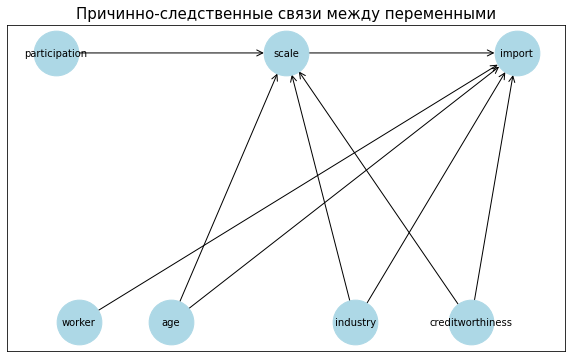

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Определяем связи между переменными
edges = [
    # Основная причинная связь
    ('scale', 'import'),        # Масштаб бизнеса влияет на объем импорта
    
    # Связи инструментальной переменной
    ('participation', 'scale'), # Участие в программе влияет на масштаб бизнеса
    
    # Контрольные переменные
    ('age', 'import'),          # Возраст компании влияет на импорт
    ('industry', 'import'),     # Отрасль влияет на импорт
    ('age', 'scale'),           # Возраст компании влияет на масштаб
    ('industry', 'scale'),       # Отрасль влияет на масштаб бизнеса
    ('worker', 'import'),       # Число сотрудников влияет на импорт
    ('industry', 'scale'),       # Число сотрудников влияет на масштаб бизнеса
    
    #Ненаблюдаемая переменная, вызывающая эндогенность
     ('creditworthiness', 'import'),          # Кредитоспособность компании влияет на импорт
    ('creditworthiness', 'scale')           # Кредитоспособность влияет на масштаб
]

# Создаем направленный граф
G = nx.DiGraph()
G.add_edges_from(edges)

# Позиционирование узлов для лучшей читаемости
pos = {
    'participation': (0, 1),
    'scale': (1, 1),
    'import': (2, 1),
    'age': (0.5, 0),
    'industry': (1.3, 0),
    'creditworthiness': (1.8, 0), 
    'worker': (0.1, 0)
}

# Настройки визуализации
nx_options = {
    'with_labels': True,
    'node_size': 2000,
    'node_color': 'lightblue',
    'font_size': 10,
    'arrowstyle': '->',
    'arrowsize': 15,
    'edge_color': 'black'
}
# Рисуем граф
plt.figure(figsize=(10, 6))
nx.draw_networkx(G, pos=pos, **nx_options)

# Добавляем заголовок
plt.title("Причинно-следственные связи между переменными", size=15)
plt.show()

3) Симулируйте данные в соответствии с предполагаемым вами процессом и приведите корреляционную матрицу, а также таблицу со следующими описательными статистиками:

• Для непрерывных переменных: выборочное среднее, выборочное стандартное отклонение, медиана, минимум и максимум.

• Для бинарных переменных: доля и количество единиц.


Указания:

• Необходимо сгенерировать не менее 1000 наблюдений.

• Доля единиц не должна быть меньше 0.1 или больше 0.9 ни для одной из
бинарных переменных.

**Генерация контрольных переменных**

In [3]:
#Генерируем Age

# Для воспроизводимости
np.random.seed(123)

# Число наблюдений
n = 10000

sko=np.sqrt(2*np.log(9/7)) #нашли СКО через медиану=7 и среднее=9

#Мы предположили, что возраст компании распределен в соответствии с логнормальным законом 
age = lognorm.rvs(s = sko, scale = 9, size = n)

# Установим ограничения на минимальные и максимальные значения
age[age >= 50] = 50
age[age <= 1]  = 1

# Введем округление
age = np.round(age)

# Посмотрим на несколько первых значений
print(age[0:15])

[ 4. 18. 11.  3.  6. 29.  2.  7. 22.  5.  6.  8. 26.  6.  7.]


<Axes: ylabel='Density'>

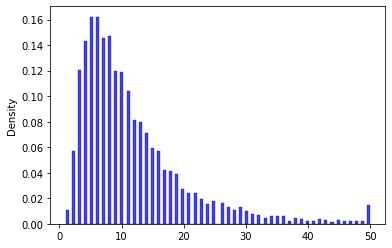

In [4]:
#Визуализируем распределение
seaborn.histplot(age,                 # данные
                 stat = 'density',           # тип гистограммы
                 color = "blue",    # цвет гистограммы
                 label = "histogram",        # наименование гистограммы
                 bins = 100)                 # число столбиков в Гистограмме


In [5]:
#Генерируем переменную Industry
industry = np.random.binomial(n = 1, p = 0.11, size = n) #Industry имеет распределение Бернулли, поскольку это - бинарная переменная, приниимающая значения 1 или 0
#Около 11% всех российских компаний относятся к высокотехнологичным секторам

# Доля высокотехнологичных предприятий
print(np.mean(industry))

# Посмотрим на несколько первых значений
print(industry[0:15])

0.1115
[1 1 0 0 0 0 0 1 0 0 0 0 1 0 1]


In [6]:
#Генерируем Worker

#общее число занятых на российских коммерческих предприятиях
k1=64500000
#общее число российских коммерческих предприятий
k2=2623091
#среднее количество работников на предприятиях
mean_number=k1/k2
sko=np.sqrt(2*np.log(24.65/5.5))
#Мы предположили, что число работников компании распределено в соответствии с логнормальным законом
worker = lognorm.rvs(s = sko, scale = mean_number, size = n)

# Установим ограничения на минимальное значение
worker[worker <= 2]  = 2

# Введем округление
worker = np.round(worker)

# Посмотрим на несколько первых значений
print(worker[0:15])

[ 14.  35.  20. 256.  23.  24. 133.   2.   2.  32.   7.  30.  59.  47.
  45.]


<Axes: ylabel='Density'>

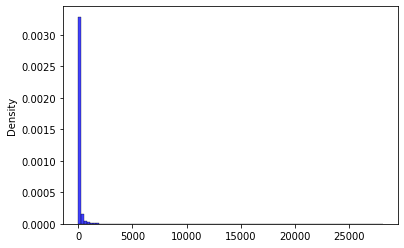

In [7]:
#Визуализируем распределение
seaborn.histplot(worker,                 # данные
                 stat = 'density',           # тип гистограммы
                 color = "blue",    # цвет гистограммы
                 label = "histogram",        # наименование гистограммы
                 bins = 100)                 # число столбиков в Гистограмме


**Генерация ненаблюдаемой переменной Creditworthiness**

In [8]:
sko=np.sqrt(2*np.log(9/7)) #нашли СКО через медиану=7 и среднее=9
from scipy.stats import beta

#Мы предположили, что кредитоспособность распределена в соответствии с бета-распределением из-за левосторонней асимметрии 

score_min = 300
score_max = 850 # Параметры диапазона рейтинга
К = score_max - score_min #Размах 

alpha = 5
beta_param = 2 # Параметры бета-распределения для левосторонней асимметрии(подобрали так, чтобы получить умеренную левостороннюю асимметрию)

creditbeta = beta.rvs(alpha, beta_param, size=n)  #Генерация

creditworthiness = score_min + creditbeta * К #Проводим vасштабирование под диапазон кредитного рейтинга

# Введем округление
creditworthiness = np.round(creditworthiness)

creditworthiness = (creditworthiness - 300) / (850 - 300)*1000 #Выплоним нормировку к диапазону от 0 до 1000, чтобы было удобнее с ней работать

# Посмотрим на несколько первых значений
print(creditworthiness[0:15])

[932.72727273 558.18181818 550.90909091 614.54545455 570.90909091
 803.63636364 469.09090909 829.09090909 418.18181818 774.54545455
 725.45454545 660.         723.63636364 761.81818182 310.90909091]


<Axes: ylabel='Density'>

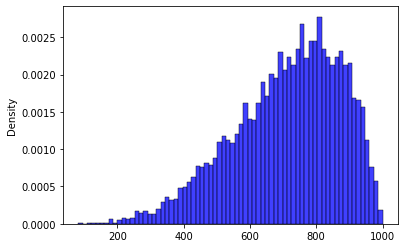

In [9]:
#Визуализируем распределение
seaborn.histplot(creditworthiness,                 # данные
                 stat = 'density',           # тип гистограммы
                 color = "blue",    # цвет гистограммы
                 label = "histogram",        # наименование гистограммы
                 bins = 70)                 # число столбиков в Гистограмме


**Генерация инструментальной переменной**

Удобно сгенерировать инструмент на основе контрольных переменных.

Для того, чтобы сгенерировать бинарную переменную как функцию от других переменных, необходимо сперва предположить форму условных вероятностей. Для этого удобно применять следующий алгоритм:

1.   Записать **индекс**, который отражает статистические связи инструментальной переменной с контрольными переменными.
2.   Сформировать условные вероятности взяв функцию распределения от этого индекса

Мы полагаем, что условная вероятность факта участия в программах государственной поддержки предприятий отрицательно коррелирует с возрастом и положительно коррелирует с фактом работы компании в высокотехнологичной отрасли и числом сотрудников:

$$\text{P}\left(\text{Participation}_{i} = 1|\text{Age}_{i}, \text{Industry}_{i}\right) = \Phi\left(\underbrace{\frac{0.3 * \text{Industry}_{i}}{ (7 + \text{Age}_{i})} - 1.5*\ln(\text{Age}_{i}) + 0.2*\ln(\text{Worker}_{i}) + 1.8}_{\text{индекс}}\right)$$

Где $\Phi()$ - функция распределения стандартного нормального распределения.

**Важно** - для удобства генерации рекомендуется предположить, что условные вероятности инструментальной переменной должны зависеть лишь от контрольных переменных.

In [10]:
# Сформируем индекс
participation_index = 0.3 * industry / (7+age) -1.5*np.log(age)+0.2*np.log(worker)+1.8
# Создадим условные вероятности
participation_prob = norm.cdf(participation_index)

# Посмотрим на несколько первых условных вероятностей
print(participation_prob[0:15])

[0.60858873 0.03495541 0.11551761 0.89636666 0.39722349 0.00445703
 0.95892534 0.16882794 0.00348856 0.53147984 0.30908092 0.26143657
 0.01183183 0.45318847 0.36839616]


In [11]:
# Факт участия компании в программе государственной поддержки предприятий
participation = np.random.binomial(n = 1, p = participation_prob, size = n)
# Первые несколько значений условных вероятностей и переменной
print(pd.DataFrame({'P(participation = 1|X)': np.round(participation_prob[0:15], 2),
                    'participation': participation[0:15]}))


    P(participation = 1|X)  participation
0                     0.61              1
1                     0.03              0
2                     0.12              0
3                     0.90              0
4                     0.40              0
5                     0.00              0
6                     0.96              1
7                     0.17              0
8                     0.00              0
9                     0.53              0
10                    0.31              0
11                    0.26              0
12                    0.01              1
13                    0.45              0
14                    0.37              0


In [12]:
# Дисперсия индекса
print(np.var(participation_index))

1.2408075927884747


In [13]:
# Доля фирм, участвующих в программе господдержки предприятий
print(np.mean(participation))

0.2899


**Генерация переменной воздействия**

Мы предполагаем, что масштаб компании зависит от ее возраста, отрасли, участия в программе господдержки и ненаблюдаемой переменной кредитоспособность. Поэтому мы будем генерировать переменную Scale на основе них. Направление связи переменной воздействия, исходя из наших предпосылок, положительное с переменными Age, Industry, Creditworthiness, Participation.

Условные вероятности переменной воздействия:
$$P(\text{Scale}_{i} = 1|\text{Participation}_{i}, \text{Age}_{i}, \text{Industry}_{i}, \text{Creditworthiness}_{i}) = \\ = F_{\text{Logistic}}\left(6.2\times \ln\left(\text{Age}_{i} +2.5\right) + 0.85\times\sqrt{\text{Creditworthiness}_{i}} + 0.03\times\text{Age}_{i}\times\text{Industry}_{i} - 48 + 7.5\times\text{Participation}_{i}+ 0.05\times\sqrt{\text{Worker}_{i}}\right)$$

Где $F_{\text{Logistic}}$ - функция распределения стандартного логистического распределения.

Для краткости введем обозначение для условной вероятности участия компании в программе государственной поддержки предприятий:

$$p_{k}^{\text{Participation}_{i}} = P(\text{Scale}_{i} = 1|\text{Participation}_{i}, \text{Age}_{i}, \text{Industry}_{i}, \text{Worker}_{i}, \text{Creditworthiness}_{i}, \text{Participation}_{i} = k)\text{, где }k\in\{0,1\}$$

Для того, чтобы впоследствии анализировать локальные средние эффекты воздействия $\text{LATE}$, необходимо различать величину переменной воздействия $\text{Scale}_{i}$ в зависимости от значения инструмента $\text{Participation}_{i}$. Для этого рассмотрим ни от чего не зависящую равномерную случайную величину $U_{i}\sim U(0,1)$ и введем гипотетические переменные:

$$\text{Scale}_{1i} = I(p_{1}^{\text{Participation}_{i}}\geq U_{i})$$

$$\text{Scale}_{0i} = I(p_{0}^{\text{Participation}_{i}}\geq U_{i})$$


$$I(\text{условие}) = \begin{cases}1\text{, если условие выполнено}\\0\text{, в противном случае}\end{cases}$$

Переменные $\text{Scale}_{1i}$ и $\text{Scale}_{0i}$ отражают потенциальные уровни масштаба фирмы в зависимости от факта участия в программе господдержки.

In [14]:
# Равномерные случайные величины
u = uniform.rvs(size = n)

In [15]:
# Сгенерируем часть индекса, не зависящую от факта того, что фирма принимала/принимает участие в программе господдержки
participation1    = 1
scale_index = 6.0 * np.log(age+2.5) + 0.95*np.sqrt(creditworthiness) + 0.03*age*industry-51+7.5*participation+0.05*np.sqrt(worker)

In [16]:
# Симулируем принадлежность к крупному бизнесу в случае, когда фирма принимала/принимает участие в программе господдержки
participation1    = 1
scale1_index = scale_index + 3 * participation1
scale1_prob  = logistic.cdf(scale1_index)
scale1       = (scale1_prob >= u).astype(int)

# Доля крупных фирм в случае, когда все фирмы принимают/принимали участие в программе господдержки
np.mean(scale1)

0.135

In [17]:
# Симулируем принадлежность к крупному бизнесу в случае, когда фирма не принимала/принимает участие в программе господдержки
participation0    = 0
scale0_index = scale_index + 3 * participation0
scale0_prob  = logistic.cdf(scale0_index, scale = 1)
scale0       = (scale0_prob >= u).astype(int)

# Доля крупных фирм в случае, когда никакие фирмы не принимают/не принимали участие в программе господдержки
np.mean(scale0)

0.034

Индивидов можно разделить на $4$ группы:


*   **Always-takers** - те, у кто $\text{Scale}_{0i}=\text{Scale}_{1i}=1$: фирма крупного масштаба независимо от того участвовала ли она в программе господдержки.
*   **Never-takers**- те, кто $\text{Scale}_{0i}=\text{Scale}_{1i}=0$: фирма НЕ крупного масштаба независимо от того участвовала ли она в программе господдержки.
*   **Compliers** - те, кто $\text{Scale}_{1i}=1$ и $\text{Scale}_{0i}=0$, то есть $\text{Scale}_{1i} > \text{Scale}_{0i}$: фирма крупного масштаба лишь в случае, если она участвовала в программе господдержки.
*   **Defiers** - те, кто $\text{Scale}_{1i}=0$ и $\text{Scale}_{0i}=1$, то есть $\text{Scale}_{1i} < \text{Scale}_{0i}$: фирма крупного масштаба лишь в случае, если она не участвовала в программе господдержки.

Для соблюдения предпосылок используемых методов важно отсутствие Defiers, что гарантируется используемым процессом генерации данных.

In [18]:
# Рассмотрим различные группы индивидов
ind_type = np.empty(n, dtype = 'U25')
ind_type[(scale1 == 1) & (scale0 == 1)] = 'Always taker'
ind_type[(scale1 == 0) & (scale0 == 0)] = 'Never taker'
ind_type[scale1 > scale0]               = 'Complier'
ind_type[scale1 < scale0]               = 'Defier'

# Посмотрим на распределение фирм разного типа
print(pd.value_counts(ind_type))

Never taker     8650
Complier        1010
Always taker     340
Name: count, dtype: int64


In [19]:
# Сравним факт принадлежности фирмы к крупному масштабу для одной и той же фирмы в случаях, 
# когда она участвовала в программе господдержки и когда она не участвовала в программе господдержки
print(pd.DataFrame(data    = np.array([scale0, scale1, ind_type]).transpose(),
                   columns = ['scale0', 'scale1', 'Тип фирмы']))

     scale0 scale1    Тип фирмы
0         0      0  Never taker
1         0      0  Never taker
2         0      0  Never taker
3         0      0  Never taker
4         0      0  Never taker
...     ...    ...          ...
9995      0      1     Complier
9996      0      0  Never taker
9997      0      0  Never taker
9998      0      0  Never taker
9999      0      1     Complier

[10000 rows x 3 columns]


Наблюдаемый в данных вид масштаба фирмы можно выразить как:

$$\text{Scale}_{i} = \begin{cases}\text{Scale}_{1i}\text{, если }\text{Participation}_{i} = 1\\ \text{Scale}_{0i}\text{, если }\text{Participation}_{i} = 0\end{cases} = \\ = \text{Scale}_{1i}\times\text{Participation}_{i} + \text{Scale}_{0i}\times\left(1 - \text{Participation}_{i}\right)$$

In [20]:
# Факт принадлежности фирмы к крупному масштабу
scale = scale1 * participation + scale0 * (1 - participation)

# Доля крупных фирм
print(np.mean(scale))

0.0901


**Важно**

*   При слабой корреляции между $\text{Scale}_{i}$ и $\text{Creditworthiness}_{i}$ проблема эндогенности окажется несущественной, а при слишком большой скорректировать эндоенность окажется чрезвычайно сложно.
*   При слабой корреляции между $\text{Scale}_{i}$ и $\text{Participation}_{i}$ инструмент не будет релевантным и поэтому не позволит скорректировать эндогенность.

Таким образом, желательно сделать так, чтобы корреляции находились в некотором разумном диапазоне:

$$0.8\geq|\text{Corr}\left(\text{Scale}_{i}, \text{Creditworthiness}_{i}\right)|\geq0.2$$

$$0.8\geq|\text{Corr}\left(\text{Scale}_{i}, \text{Participation}_{i}\right)|\geq0.2$$

In [21]:
# Рассмотрим корреляции
print(pd.DataFrame(data    = [np.corrcoef(scale, creditworthiness)[0, 1],
                              np.corrcoef(scale, participation)[0, 1]],
                   index   = ['Corr(scale, creditworthiness)',
                              'Corr(scale, participation)'],
                   columns = ['Оценка']))

                                 Оценка
Corr(scale, creditworthiness)  0.238575
Corr(scale, participation)     0.409360


**Генерация целевой переменной**

Сформируем представления о формировании потенциальном ожидаемом объеме импорта в зависимости от принадлежности фирмы к крупному бизнесу.

**Основная идея** - отдача от возраста и кредитоспособности выше в случае, когда фирма получала государственную поддержку.

Уравнение ожидаемого объема импорта когда фирма не относится к крупному бизнесу:

$$\text{Import}_{0i} = \underbrace{\underbrace{0.009\times\text{Creditworthiness}_{i}}_{g_{0}^{\text{unobs}}}  \underbrace{-35 + 0.01\times\frac{\text{Age}_{i}}{10 -\text{3*Industry}_{i}-\text{7.77*Wroker}_{i}}+1\times\ln(\text{Age}_{i}+0.2\times\text{Worker}_{i})+3\times\text{Industry}_{i}}_{g_{0}^{\text{obs}}}}_{g_{0}} + \varepsilon_{0i}\text{, где }\varepsilon_{0i}\sim \left(5\times t(8)\right)$$  

Уравнение ожидаемого объема импорта когда фирма относится к крупному бизнесу::

$$\text{Import}_{1i} = \underbrace{\underbrace{0.01\times\text{Creditworthiness}_{i}}_{g_{1}^{\text{unobs}}} \underbrace{-24 + 0.03\times\sqrt{\text{Age}_{i}\times\text{Industry}_{i}+5\times\text{Worker}_{i}}+16\times\ln(\text{Age}_{i}+0.4\times\text{Worker}_{i})+8\times\text{Industry}_{i}}_{g_{1}^{\text{obs}}}}_{g_{1}} + \varepsilon_{1i}\text{, где }\varepsilon_{1i}\sim \left(4\times t(9)\right)$$ 

Наблюдаемый ожидаемый объем импорта:

$$\text{Import}_{i} = \begin{cases}\text{Import}_{1i}\text{, если }\text{Scale}_{i}=1\\ \text{Import}_{0i}\text{, если }\text{Scale}_{i}=0\end{cases} = \\ =\text{Import}_{1i}\times\text{Scale}_{i} + \text{Import}_{0i}\times\left(1-\text{Scale}_{i}\right)$$

In [22]:
# Случайные ошибки
error0 = t.rvs(size = n, df = 8) * 5
error1 = t.rvs(size = n, df = 9) * 4

# Функция от контрольных переменных
  # когда масштаб бизнеса не крупный
g0_obs   = -35 + 0.01*age/(10-30*industry-7.77*worker)+10*np.log(age+0.2*worker)+3*industry
g0_unobs =  0.009 * creditworthiness
g0       = g0_obs + g0_unobs
  # когда масшта0б бизнеса крупный
g1_obs   = -24 + 0.03*np.sqrt(age *industry+5*worker )+16*np.log(age+0.4*worker)+8*industry
g1_unobs = 0.01*creditworthiness
g1       = g1_obs + g1_unobs

# Ожидаемый объем импорта в зависимости от масштаба(принадлежности к крупному бизнесу):
import0 = g0 + error0
import1 = g1 + error1

# Наблюдаемый ожидаемый объем импорта
import_ = import1 * scale + import0 * (1 - scale)
#Обрежем нулевые значения
import_ = np.maximum(import_, 0)

<Axes: ylabel='Density'>

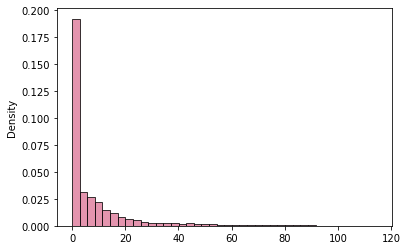

In [23]:
# Посмотрим на распределение ожидаемого объема импорта
seaborn.histplot(import_,                  # данные
                 stat  = 'density',          # тип гистограммы
                 color = "palevioletred",    # цвет гистограммы
                 label = "histogram",        # наименование гистограммы
                 bins  = 40)                 # число столбиков в Гистограмме

In [24]:
print(np.mean(import_))

8.233241411291818


Во избежание чрезвычайно точных или крайне неточных оценок, желательно, чтобы при каждом $j\in\{0, 1\}$ дисперсии $\varepsilon_{ji}$, $g_{j}$, $g_{j}^{\text{obs}}$ и  $g_{j}^{\text{unobs}}$ различались не более, чем в $5$ раз.

In [25]:
# Приблизительно оценим адекватность дисперсий
print(pd.DataFrame(data    = [np.var(error0),   np.var(g0),
                              np.var(g0_obs),   np.var(g0_unobs),
                              np.var(error1),   np.var(g1),
                              np.var(g1_obs),   np.var(g1_unobs),
                              np.var(import_)],
                   index   = ['Var(eps0)',     'Var(g0)',
                              'Var(g0_obs)',   'Var(g0_unobs)',
                              'Var(eps1)',     'Var(g1)',
                              'Var(g1_obs)',   'Var(g1_unobs)',
                              'Var(import_)'],
                   columns = ['Оценка']))

                   Оценка
Var(eps0)       33.286596
Var(g0)         82.567866
Var(g0_obs)     80.359469
Var(g0_unobs)    2.124940
Var(eps1)       20.330456
Var(g1)        287.471462
Var(g1_obs)    284.656551
Var(g1_unobs)    2.623382
Var(import_)   217.896215


**Подведем итог генерации данных**

In [26]:
!pip install prettytable

In [27]:
from prettytable import PrettyTable


# Создание таблицы
tableSummary = PrettyTable()
tableSummary.field_names = ["", "Age", "Industry", "Worker", "Creditwothiness", "Participation", "Scale", "Import"]

# Добавляем строки
tableSummary.add_row(["Закон распределения","Логнормальный", "Бернулли", "Логнормальный", "Бета-распределение", "Условное", "Условное", "Условное"])
tableSummary.add_row(["Параметры", "scale=9, std=0.71",  "p=0.11", "scale=24.65, std=1.73", "alpha=2, beta=5", "", "", ""])
tableSummary.add_row(["Cреднее/Доля единиц", age.mean(), industry.mean() ,worker.mean(), creditworthiness.mean().round(3), participation.mean(), scale.mean(), import_.mean().round(3)])

tableSummary.max_width[""] = 13
tableSummary.max_width["Age"] =  8
tableSummary.max_width["Industry"] =  8
tableSummary.max_width["Worker"] =  8
tableSummary.max_width["Creditwothiness"] =  8
tableSummary.max_width["Participation"] =  8
tableSummary.max_width["Scale"] =  8
tableSummary.max_width["Import"] =  8
print(tableSummary)

+---------------+----------+----------+----------+-----------------+---------------+----------+----------+
|               |   Age    | Industry |  Worker  | Creditwothiness | Participation |  Scale   |  Import  |
+---------------+----------+----------+----------+-----------------+---------------+----------+----------+
|     Закон     | Логнорма | Бернулли | Логнорма |      Бета-      |    Условное   | Условное | Условное |
| распределения |  льный   |          |  льный   |  распределение  |               |          |          |
|   Параметры   | scale=9, |  p=0.11  | scale=24 | alpha=2, beta=5 |               |          |          |
|               | std=0.71 |          |   .65,   |                 |               |          |          |
|               |          |          | std=1.73 |                 |               |          |          |
|  Cреднее/Доля | 11.5338  |  0.1115  | 106.5554 |     713.651     |     0.2899    |  0.0901  |  8.233   |
|     единиц    |          |         

**Объединение данных**

In [28]:
# Аггрегируем данные в датафрейм
df = pd.DataFrame({'import': import_, 'scale': scale,
                   'age': age, 'industry': industry,'participation': participation,  'worker': worker})
df = df.loc[0:n, :]

# Посмотрим на симулированные данные
df.head(10).style.format(precision = 2)

,import,scale,age,industry,participation,worker
0,0.00,0,4.00,1,1,14.00
1,11.58,0,18.00,1,0,35.00
2,1.83,0,11.00,0,0,20.00
3,8.46,0,3.00,0,0,256.00
4,3.63,0,6.00,0,0,23.00
5,16.95,0,29.00,0,0,24.00
6,0.00,0,2.00,0,1,133.00
7,0.00,0,7.00,1,0,2.00
8,0.00,0,22.00,0,0,2.00
9,0.00,0,5.00,0,0,32.00


In [29]:
#Приведем корреляционную матрицу.
print(df.astype(float).corr(method = 'pearson'))

                 import     scale       age  industry  participation    worker
import         1.000000  0.796975  0.152889  0.058746       0.286080  0.373163
scale          0.796975  1.000000  0.011745  0.013913       0.409360  0.087203
age            0.152889  0.011745  1.000000 -0.020604      -0.421725 -0.002276
industry       0.058746  0.013913 -0.020604  1.000000       0.036246  0.002111
participation  0.286080  0.409360 -0.421725  0.036246       1.000000  0.062036
worker         0.373163  0.087203 -0.002276  0.002111       0.062036  1.000000


In [30]:
#Для непрерывных переменных приведем описательные статистики
df.agg({'import': ['mean', 'std', 'median', 'min', 'max'],
             'age': ['mean', 'std', 'median', 'min', 'max'],
       'worker': ['mean', 'std', 'median', 'min', 'max']})

,import,age,worker
mean,8.233241,11.533800,106.555400
std,14.762046,8.684549,442.732855
median,1.424639,9.000000,24.000000
min,0.000000,1.000000,2.000000
max,114.435614,50.000000,28072.000000


In [31]:
#Для бинарных переменных приведем долю и количество единиц
df.agg({'scale': ['mean', 'sum'],
             'industry': ['mean', 'sum'],
             'participation': ['mean', 'sum'] })

,scale,industry,participation
mean,0.0901,0.1115,0.2899
sum,901.0000,1115.0000,2899.0000


4. Разделите выборку на обучающую и тестовую. Тестовая выборка должна включать от 20% до 30% наблюдений.

Разделим сразу для выполнения пункта 3(не включая целевую переменную импорт)

In [32]:
from sklearn.model_selection import train_test_split
# Разделим целевую переменную и признаки
target   = df.loc[:, ['scale']]            # целевая переменная
features = df.loc[:, ["age", "industry", "worker", "participation"]]    # матрица признаков
target   = np.squeeze(target)                # преобразуем из вектора столбца
                                             # в одномерный массив
# Разделим выборку на обучающую и тестовую
# с помощью автоматической функции
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.2, random_state = 777)

# Убедимся, что обучающая и тестовая выборки имеют верные пропорции
print(features_train.index.size, features_test.index.size) # признаки
print(target_train.index.size, target_test.index.size)     # целевая переменная

8000 2000
8000 2000


****3 Классификация****


В каждом из заданий, если не сказано иного, необходимо использовать хотя бы 3
(на ваш выбор) из следующих методов: наивный Байесовский классификатор, метод


In [34]:
!python.exe -m pip install --upgrade pip
!pip install numpy==1.26.4
!pip install pandas # 1.5.3
!pip install scikit-learn
!pip install openpyxl
exit()

/bin/sh: 1: python.exe: Permission denied
ERROR: Could not find a version that satisfies the requirement numpy==1.26.4 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.3, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5, 1.20.0, 1.20.1, 1.20.2, 1.20.3, 1.21.0, 1.21.1, 1.21.2, 1.21.3, 1.21.4, 1.21.5, 1.21.6, 1.22.0, 1.22.1, 1.22.2, 1.22.3, 1.22.4, 1.23.0, 1.23.1, 1.23.2, 1.23.3, 1.23.4, 1.23.5, 1.24.0, 1.24.1, 1.24.2, 1.24.3, 1.24.4)
ERROR: No matching distribution found for numpy==1.26.4


In [33]:
# Подключим необходимые библиотеки
import numpy as np                                        # базовые операции с массивами
import pandas as pd                                       # базовые операции с датафреймами
from   sklearn.naive_bayes import CategoricalNB           # наивный Байесовский классификатор
from   sklearn.model_selection import train_test_split    # разделение выборки на
                                                          # обучающую и тестовую
from   sklearn.model_selection import cross_val_score     # кросс-валидация
from   sklearn.model_selection import KFold               # разбиение на части (folds)
import openpyxl                                           # работа с excel
import matplotlib.pyplot as plt                           # графики
from   sklearn.metrics import confusion_matrix            # подсчет прогнозов
from   sklearn.neighbors import KNeighborsClassifier      # метод ближайшие соседей
import sklearn
from   sklearn.model_selection import GridSearchCV        # подбор гиперпараметров
from   sklearn.model_selection import RandomizedSearchCV  # подбор гиперпараметров
import scipy                                              # распределения
from   sklearn.metrics import RocCurveDisplay             # ROC-кривая
from   sklearn import metrics                             # метрики точности
import itertools

from   sklearn.utils import shuffle                       # случайная перестановка
from   sklearn.inspection import DecisionBoundaryDisplay  # границы решений


1. Отберите признаки, которые могут быть полезны при прогнозировании переменной воздействия и обоснуйте выбор каждой из них. Не включайте в число
этих признаков целевую переменную.

Для того, чтобы выбрать переменные, полезные при прогнозированные переменной Scale, нам следует составить корреляционную матрицу без учета импорта, поскольку в данной задаче корреляция с импортом не имеет значения.

In [34]:
# Удаляем колонку 'import' и считаем корреляционную матрицу, поскольку в данном задании мы ее не испоьлзуем и следовательно нам нужно очистить корреляции т ее влияния
correlation_matrix1 = df.drop(columns=['import']).corr()
# Выводим матрицу
print(correlation_matrix1)


                  scale       age  industry  participation    worker
scale          1.000000  0.011745  0.013913       0.409360  0.087203
age            0.011745  1.000000 -0.020604      -0.421725 -0.002276
industry       0.013913 -0.020604  1.000000       0.036246  0.002111
participation  0.409360 -0.421725  0.036246       1.000000  0.062036
worker         0.087203 -0.002276  0.002111       0.062036  1.000000


Ранее мы уже создали тестовую и обучающую выборки с данными переменными, она не включает переменную Импорт

Как мы видим, переменная scale коррелирует только с переменной participation, с остальными переменными ее корреляция слабая, поэтому выполним оценку важности признаков

In [35]:
# Сохраним число наблюдений обучающей и тестовой выборок
n_train = len(target_train)
n_test  = len(target_test)

# Вернем исходную сортировку индексов
features_train = features_train.reset_index(drop = True)
target_train   = target_train.reset_index(drop = True)
features_test  = features_test.reset_index(drop = True)
target_test    = target_test.reset_index(drop = True)

Выполним нормализацию данных

Обозначим через $X_{*j}$ столбец $j$ в матрице признаков $X$, то есть $j$-й признак. Через $\tilde{X}$ обозначим матрицу нормализованных признаков.

Наиболее распространенный способ нормализации данных:
$\tilde{X}_{ij} = \frac{X_{ij} - \overline{X}_{*j}}{\sqrt{\hat{\sigma}^{2}_{j}}}$

In [36]:
# Сохраним данные до нормализации
features_train_initial = features_train.copy()
features_test_initial  = features_test.copy()

# Подготовим объект, осуществляющий нормализацию
scaler = sklearn.preprocessing.StandardScaler().set_output(transform = "pandas").fit(features_train)

# Нормализуем данные
features_train = scaler.transform(features_train_initial)  # обучающая выборка
features_test  = scaler.transform(features_test_initial)   # тестовая выборка

**Оценка важности признаков с помощью методов классификации**

Рисуем после выполнения каждого метода гистограмму важностей признаков, чтобы можно было визуально сравнить, какие признаки важнее всего для классификации.



In [37]:
#Случайный лес
from sklearn.ensemble import RandomForestClassifier
forest_class = RandomForestClassifier()

forest_class.fit(features_train, target_train)

RandomForestClassifier()

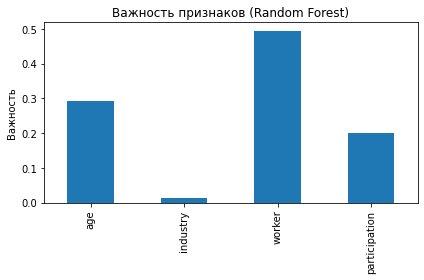

In [38]:
#Считаем важности признаков
importances_rf = pd.Series(forest_class.feature_importances_, index=features_train.columns)

# Строим график
importances_rf.plot.bar()
plt.title('Важность признаков (Random Forest)')
plt.ylabel('Важность')
plt.tight_layout()
plt.show()

In [39]:
#Логистическая регрессия
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(features_train, target_train)

LogisticRegression()

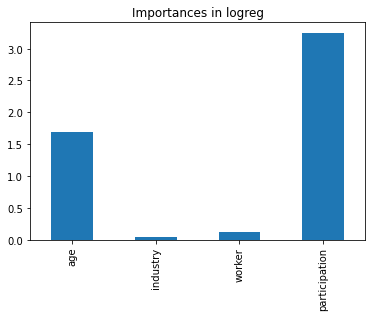

In [40]:
#Считаем важности признаков
importances_lr = pd.Series(logreg.coef_[0], index = features_train.columns)
importances_lr.plot.bar()
# Строим график
plt.title('Importances in logreg')
plt.show()

In [41]:
#Градиентный бустинг
from sklearn.ensemble import GradientBoostingClassifier
boosting_class = GradientBoostingClassifier()

boosting_class.fit(features_train, target_train)

GradientBoostingClassifier()

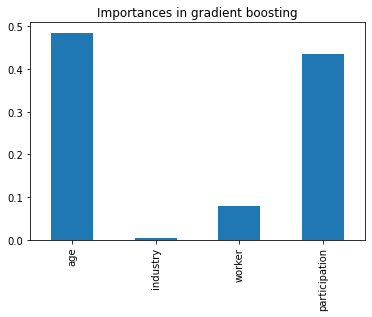

In [42]:
#Считаем важности признаков
importances_gb = pd.Series(boosting_class.feature_importances_, index = features_train.columns)
importances_gb.plot.bar()
# Строим график
plt.title('Importances in gradient boosting')
plt.show()

Видим, что выбранные переменные важны для предсказания переменной воздействия, за исключением переменной **Industry**, поэтому мы можем далее создать новые обучающую и тестовые выборки **без нее**

In [43]:
from sklearn.model_selection import train_test_split
# Разделим целевую переменную и признаки
target3   = df.loc[:, ['scale']]            # целевая переменная
features3 = df.loc[:, ["age", "worker", "participation"]]    # матрица признаков
target3   = np.squeeze(target)                # преобразуем из вектора столбца
                                             # в одномерный массив
# Разделим выборку на обучающую и тестовую
# с помощью автоматической функции
features_train3, features_test3, target_train3, target_test3 = train_test_split(
    features3, target3, test_size = 0.2, random_state = 777)

# Убедимся, что обучающая и тестовая выборки имеют верные пропорции
print(features_train3.index.size, features_test3.index.size) # признаки
print(target_train3.index.size, target_test3.index.size)     # целевая переменная

8000 2000
8000 2000


2. Выберите произвольные значения гиперпараметров, а затем оцените и сравните
(между методами) точность прогнозов:

• на обучающей выборке.

• на тестовой выборке.

• с помощью кросс-валидации (используйте только обучающую выборку).

Проинтерпретируйте полученные результаты.


In [44]:
#Количество фолдов
NFOLDS = 5

In [45]:
#Создаем датафрейм в котором отоборазим результаты пункта 2.2
class_metrics = pd.DataFrame(index=['ACC обучающая выборка', 'ACC тестовая выборка', 'ACC Кросс-валидация', 'Гиперпараметры'])

**Метод ближайших соседей**

In [46]:
knn_class = KNeighborsClassifier()

knn_class.fit(features_train3, target_train3)

ACC_knn_train = knn_class.score(features_train3, target_train3)  # обучающая выборка

ACC_knn_test  = knn_class.score(features_test3, target_test3) # тестовая выборка

knn_cv = cross_val_score(KNeighborsClassifier(),
                           features_train3,
                           target_train3,
                           cv=NFOLDS).mean()

class_metrics['kNN'] = [ACC_knn_train, ACC_knn_test, knn_cv, knn_class.get_params()]

**Градиентный бустинг**

In [47]:
boosting_class = GradientBoostingClassifier()

boosting_class.fit(features_train3, target_train3)

ACC_boosting_train = boosting_class.score(features_train3, target_train3)  # обучающая выборка

ACC_boosting_test  = boosting_class.score(features_test3, target_test3) # тестовая выборка

boosting_cv = cross_val_score(GradientBoostingClassifier(),
                           features_train,
                           target_train3,
                           cv=NFOLDS).mean()

class_metrics['Бустинг'] = [ACC_boosting_train, ACC_boosting_test,
                              boosting_cv, boosting_class.get_params()]

**Случайный лес**

In [48]:
forest_class = RandomForestClassifier()

forest_class.fit(features_train3, target_train3)

ACC_rf_train = forest_class.score(features_train3, target_train3)  # обучающая выборка

ACC_rf_test  = forest_class.score(features_test3, target_test3) # тестовая выборка

rf_cv = cross_val_score(RandomForestClassifier(),
                           features_train3,
                           target_train3,
                           cv=NFOLDS).mean()

class_metrics['Случ. лес'] = [ACC_rf_train, ACC_rf_test,
                              rf_cv, forest_class.get_params()]

**Логистическая регрессия**

In [49]:
logreg = LogisticRegression()

logreg.fit(features_train3, target_train3)

ACC_logreg_train = logreg.score(features_train3, target_train3)  # обучающая выборка

ACC_logreg_test  = logreg.score(features_test3, target_test3) # тестовая выборка

logreg_cv = cross_val_score(LogisticRegression(),
                           features_train3,
                           target_train3,
                           cv=NFOLDS).mean()

class_metrics['Логрегрессия'] = [ACC_logreg_train, ACC_logreg_test,
                              logreg_cv, logreg.get_params()]

In [50]:
#Посмотрим на результаты
class_metrics.T

,ACC обучающая выборка,ACC тестовая выборка,ACC Кросс-валидация,Гиперпараметры
kNN,0.9175,0.9015,0.901,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
Бустинг,0.92975,0.926,0.9225,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."
Случ. лес,0.969625,0.9035,0.90225,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
Логрегрессия,0.91825,0.9135,0.91775,"{'C': 1.0, 'class_weight': None, 'dual': False..."


Выводы: все модели обладают высокой точностью

Самая высокая точность прогноза:
- на обучающей выборке - у случайного леса
- на тестовой выборке - у градиентого бустинга
- на кросс-валидации - у градиентого бустинга

Худшую точность во всех прогнозах у метода KNN
При выполнении алгоритма случайного леса, вероятно, произошло переобучение


3. Для каждого метода с помощью кросс-валидации на обучающей выборке подберите оптимальные значения гиперпараметров (тюнинг). В качестве критерия
качества используйте точность ACC. Результат представьте в форме таблицы,
в которой для каждого метода должны быть указаны:

• изначальные и подобранные значения гиперпараметров.

• кросс-валидационная точность на обучающей выборке с исходными и подобранными значениями гиперпараметров.

• точность на тестовой выборке с исходными и подобранными значениями
гиперпараметров.

In [51]:
#Используем точность ACC
CRITERION = 'accuracy'

**Метод ближайших соседей**

In [52]:
knn_params = {
    'n_neighbors': [3, 5, 7],
    'p': [1, 2, 3]
}

gs = GridSearchCV(estimator=KNeighborsClassifier(),
                  param_grid=knn_params,
                  cv=NFOLDS,
                  scoring=CRITERION)

gs.fit(features_train3, target_train3)

knn_best = gs.best_estimator_

ACC_train = knn_best.score(features_train3, target_train3)  # обучающая выборка

ACC_test  = knn_best.score(features_test3, target_test3) # тестовая выборка

ACC_cv = cross_val_score(knn_best,
                        features_train3,
                        target_train3,
                        cv=NFOLDS).mean()

class_metrics['kNN (подобр.)'] = [ACC_train,
                                  ACC_test,
                                  ACC_cv,
                                  gs.best_params_]

**Градиентный бустинг**

In [53]:
boosting_params = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 4]
}


gs = GridSearchCV(estimator=GradientBoostingClassifier(),
                  param_grid=boosting_params,
                  cv=NFOLDS,
                  scoring=CRITERION)

gs.fit(features_train3, target_train3)

boosting_best = gs.best_estimator_

ACC_train = boosting_best.score(features_train3, target_train3)  # обучающая выборка

ACC_test  = boosting_best.score(features_test3, target_test3) # тестовая выборка

ACC_cv = cross_val_score(boosting_best,
                       features_train3,
                        target_train3,
                        cv=NFOLDS).mean()

class_metrics['Бустинг (подобр.)'] = [ACC_train,
                                    ACC_test,
                                    ACC_cv,
                                    gs.best_params_]

**Случайный лес**

In [54]:
rf_params = {
    'max_depth': range(2, 20),
    'n_estimators': [50, 100]
}

gs = GridSearchCV(estimator=RandomForestClassifier(),
                  param_grid=rf_params,
                  cv=NFOLDS,
                  scoring=CRITERION)

gs.fit(features_train3, target_train3)

rf_best = gs.best_estimator_

ACC_train = rf_best.score(features_train3, target_train3)  # обучающая выборка

ACC_test  = rf_best.score(features_test3, target_test3) # тестовая выборка

ACC_cv = cross_val_score(rf_best,
                        features_train3,
                        target_train3,
                        cv=NFOLDS).mean()

class_metrics['Случ. лес (подобр.)'] = [ACC_train,
                                    ACC_test,
                                    ACC_cv,
                                    gs.best_params_]

**Логистическая регрессия**

In [55]:
logreg_params = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300],
    'C': [0.01, 0.1, 1, 10]
}

gs = GridSearchCV(estimator=LogisticRegression(),
                  param_grid=logreg_params,
                  cv=NFOLDS,
                  scoring=CRITERION)

gs.fit(features_train3, target_train3)


logreg_best = gs.best_estimator_

ACC_train = logreg_best.score(features_train3, target_train3)  # обучающая выборка

ACC_test  = logreg_best.score(features_test3, target_test3) # тестовая выборка

ACC_cv = cross_val_score(logreg_best,
                        features_train3,
                        target_train3,
                        cv=NFOLDS).mean()

class_metrics['Логрегрессия (подобр.)'] = [ACC_train,
                                    ACC_test,
                                    ACC_cv,
                                    gs.best_params_]

In [57]:
class_metrics.T

,ACC обучающая выборка,ACC тестовая выборка,ACC Кросс-валидация,Гиперпараметры
kNN,0.9175,0.9015,0.901,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
Бустинг,0.92975,0.926,0.9225,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."
Случ. лес,0.969625,0.9035,0.90225,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
Логрегрессия,0.91825,0.9135,0.91775,"{'C': 1.0, 'class_weight': None, 'dual': False..."
kNN (подобр.),0.914375,0.9055,0.9055,"{'n_neighbors': 7, 'p': 1}"
Бустинг (подобр.),0.92975,0.9265,0.923,"{'max_depth': 3, 'min_samples_leaf': 4}"
Случ. лес (подобр.),0.928,0.927,0.922,"{'max_depth': 6, 'n_estimators': 50}"
Логрегрессия (подобр.),0.918625,0.914,0.91875,"{'C': 10, 'max_iter': 100, 'solver': 'newton-cg'}"


Вывод: видим, что в некоторых случаях подбор параметров повысил качество результатов, в частности по тестовой выборке и на кросс-валидации

Лучшая точность прогнозов:

- на обучающей выборке осталась у случаного леса, но снизилась(это не обязательно плохо, поскольку слишком высокая точность на обучающей выборке может свидетельствовать о переобучении)
- на тестовой выборке стала у случайного леса
- на кросс-валидации осталась у бустинга


Худшая точность прогнозов во всех случаях осталась у KNN

**Повышенная сложность**: 

Подберите на обучающей выборке оптимальные
значения гиперпараметров случайного леса ориентируясь на значение OOB
4
(out-of-bag) ошибки. Сопоставьте гиперпараметры и точность на тестовой выборке для случайного леса в зависимости от того, используется кросс-валидация
или OOB ошибка. Объясните преимущества и недостатки OOB ошибки по сравнению с кросс-валидацей.

In [58]:
from sklearn.ensemble import RandomForestClassifier

# Определим диапазон параметров для поиска
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [59]:
# Создадим базовую модель с использованием OOB
rf = RandomForestClassifier(oob_score=True, random_state=777)

In [60]:
# Подбор параметров с OOB
best_oob_score = -1
best_params = {}

# Перебор комбинаций параметров
for n in param_grid['n_estimators']:
    for depth in param_grid['max_depth']:
        for split in param_grid['min_samples_split']:
            for leaf in param_grid['min_samples_leaf']:
                for features in param_grid['max_features']:
                    rf.set_params(
                        n_estimators=n,
                        max_depth=depth,
                        min_samples_split=split,
                        min_samples_leaf=leaf,
                        max_features=features
                    )
                    rf.fit(features_train3, target_train3)
                                        
                    # Используем OOB score как метрику
                    current_oob = rf.oob_score_
                    
                    if current_oob > best_oob_score:
                        best_oob_score = current_oob
                        best_params = {
                            'n_estimators': n,
                            'max_depth': depth,
                            'min_samples_split': split,
                            'min_samples_leaf': leaf,
                            'max_features': features
                        }

In [61]:
# Лучшая модель по OOB
best_rf_oob = RandomForestClassifier(
    oob_score=True,
    random_state=777,
    **best_params
)
best_rf_oob.fit(features_train3, target_train3)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, oob_score=True, random_state=777)

In [62]:
# Оценка на тестовой выборке
oob_test_score = best_rf_oob.score(features_test3, target_test3)

print("Лучшие параметры по OOB:", best_params)
print("OOB score:", best_oob_score)
print("Точность на тестовой выборке:", oob_test_score)

Лучшие параметры по OOB: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
OOB score: 0.92225
Точность на тестовой выборке: 0.92


In [63]:
# Кросс-валидация из исходного кода
rf_cv = cross_val_score(RandomForestClassifier(),
                       features_train3,
                       target_train3,
                       cv=NFOLDS).mean()

In [64]:
# Создаем таблицу сравнения
comparison = pd.DataFrame({
    'Метод': ['Кросс-валидация', 'OOB ошибка'],
    'Точность на тестовой выборке': [ACC_rf_test, oob_test_score],
    'Гиперпараметры': [gs.best_params_, best_params]
})

print(comparison)

             Метод  Точность на тестовой выборке  \
0  Кросс-валидация                        0.9035   
1       OOB ошибка                        0.9200   

                                      Гиперпараметры  
0  {'C': 10, 'max_iter': 100, 'solver': 'newton-cg'}  
1  {'n_estimators': 200, 'max_depth': 5, 'min_sam...  


По результатам сравнения видим, что исопьлзование OOB ошибки для подбора оптимальных параметров модели увеличило точность на тестовой выборке по сравнению с кросс-валидацией, тем не менее, обоими способами мы получили высокую точность

**Преимущества и недостатки OOB ошибки по сравнению с кросс-валидацией**


Преимущества OOB:


1)Выполняется быстрее, чем кросс-валидация: модель обучается один раз, оценка идёт по данным, не попавшим в конкретное дерево.

2)ООВ встроена в случайный лес: пользователю не надо писать отдельный код или запускать GridSearchCV.

3)При использовании ООВ нет необходимости явно выделять валидационные фолды.





Недостатки OOB:

1)Применима только к bagging-моделям (RandomForest и т.д.). Для логрегрессии, бустинга — не применимо.


2)Отличается ограниченными возможностями настройки: нельзя выбрать число фолдов или стратифицированное разбиение.


3)Потенциально более высокая дисперсия - Оценка может быть более вариативной, чем в кросс-валидации, поскольку обладает потенциально более высокйо дисперсией.




4. Повторите предыдущий пункт, используя любой альтернативный критерий качества модели. Обоснуйте возможные преимущества и недостатки этого альтернативного критерия.

Используем метрику F1-score

In [65]:
# CRITERION = 'f1'
CRITERION = 'f1'

**Метод ближайших соседей**

In [66]:
knn_params = {
    'n_neighbors': [3, 5, 7],
    'p': [1, 2, 3]
}

gs = GridSearchCV(estimator=KNeighborsClassifier(),
                  param_grid=knn_params,
                  cv=NFOLDS,
                  scoring=CRITERION)

gs.fit(features_train3, target_train3)

knn_best = gs.best_estimator_

ACC_train = knn_best.score(features_train3, target_train3)  # обучающая выборка

ACC_test  = knn_best.score(features_test3, target_test3) # тестовая выборка

ACC_cv = cross_val_score(knn_best,
                        features_train3,
                        target_train3,
                        cv=NFOLDS).mean()

class_metrics['kNN F1(подобр.)'] = [ACC_train,
                                  ACC_test,
                                  ACC_cv,
                                  gs.best_params_]

**Градиентный бустинг**

In [67]:
boosting_params = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 4]
}


gs = GridSearchCV(estimator=GradientBoostingClassifier(),
                  param_grid=boosting_params,
                  cv=NFOLDS,
                  scoring=CRITERION)

gs.fit(features_train3, target_train3)

boosting_best = gs.best_estimator_

ACC_train = boosting_best.score(features_train3, target_train3)  # обучающая выборка

ACC_test  = boosting_best.score(features_test3, target_test3) # тестовая выборка

ACC_cv = cross_val_score(boosting_best,
                       features_train3,
                        target_train3,
                        cv=NFOLDS).mean()

class_metrics['Бустинг F1(подобр.)'] = [ACC_train,
                                    ACC_test,
                                    ACC_cv,
                                    gs.best_params_]

**Случайный лес**

In [68]:
rf_params = {
    'max_depth': range(2, 20),
    'n_estimators': [50, 100]
}

gs = GridSearchCV(estimator=RandomForestClassifier(),
                  param_grid=rf_params,
                  cv=NFOLDS,
                  scoring=CRITERION)

gs.fit(features_train3, target_train3)

rf_best = gs.best_estimator_

ACC_train = rf_best.score(features_train3, target_train3)  # обучающая выборка

ACC_test  = rf_best.score(features_test3, target_test3) # тестовая выборка

ACC_cv = cross_val_score(rf_best,
                        features_train3,
                        target_train3,
                        cv=NFOLDS).mean()

class_metrics['Случ. лес F1(подобр.)'] = [ACC_train,
                                    ACC_test,
                                    ACC_cv,
                                    gs.best_params_]

**Логистическая регрессия**

In [69]:
logreg_params = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300],
    'C': [0.01, 0.1, 1, 10]
}

gs = GridSearchCV(estimator=LogisticRegression(),
                  param_grid=logreg_params,
                  cv=NFOLDS,
                  scoring=CRITERION)

gs.fit(features_train3, target_train3)


logreg_best = gs.best_estimator_

ACC_train = logreg_best.score(features_train3, target_train3)  # обучающая выборка

ACC_test  = logreg_best.score(features_test3, target_test3) # тестовая выборка

ACC_cv = cross_val_score(logreg_best,
                        features_train3,
                        target_train3,
                        cv=NFOLDS).mean()

class_metrics['Логрегрессия F1(подобр.)'] = [ACC_train,
                                    ACC_test,
                                    ACC_cv,
                                    gs.best_params_]

In [71]:
class_metrics.T

,ACC обучающая выборка,ACC тестовая выборка,ACC Кросс-валидация,Гиперпараметры
kNN,0.9175,0.9015,0.901,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
Бустинг,0.92975,0.926,0.9225,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."
Случ. лес,0.969625,0.9035,0.90225,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
Логрегрессия,0.91825,0.9135,0.91775,"{'C': 1.0, 'class_weight': None, 'dual': False..."
kNN (подобр.),0.914375,0.9055,0.9055,"{'n_neighbors': 7, 'p': 1}"
Бустинг (подобр.),0.92975,0.9265,0.923,"{'max_depth': 3, 'min_samples_leaf': 4}"
Случ. лес (подобр.),0.928,0.927,0.922,"{'max_depth': 6, 'n_estimators': 50}"
Логрегрессия (подобр.),0.918625,0.914,0.91875,"{'C': 10, 'max_iter': 100, 'solver': 'newton-cg'}"
kNN F1(подобр.),0.929,0.8925,0.896125,"{'n_neighbors': 3, 'p': 1}"
Бустинг F1(подобр.),0.934,0.9275,0.92075,"{'max_depth': 4, 'min_samples_leaf': 4}"


Вывод: видим, что практически во всех случаях(кроме kNN) подбор параметров повысил качество результатов по сравнению с первоначальной оценкой, но снизил по сравнению с этапом подбора параметров

Лучшая точность прогнозов:

- на обучающей выборке осталась у случайного леса
- на тестовой выборке стала у бустинга и снизилась по сравнению с Бустинг (подобр.)
- на кросс-валидации осталась у бустинга, но снизилась аналогично

Худшая точность прогнозов во всех случаях осталась у KNN

Преимущества F1-score:

- Данный метод учитывает как точность, так и полноту, что может быть полезно при несбалансированных классах(как в нашем случае, поскольку всего лишь 9% компаний относятся к крупным)
- Является более информативным, чем метрика accuracy, когда важно не пропускать редкие, но важные классы


Недостатки F1-score:

- Не принимает во внимание количество верно предсказанных отрицательных примеров, что может исказить представление о качестве модели, особенно когда таких наблюдений много.

- Может не отражать дисбаланс между точностью и полнотой, если одна из этих метрик значительно хуже, чем другая — итоговое значение F1-score может быть достаточно высоким, что в свою очередь исказит представление о качестве модели.


**Повышенная сложность:** дополнительно самостоятельно запрограммируйте
не представленный в стандартных библиотеках критерий качества и используйте его для тюнинга гиперпараметров. Сравните результат стандартного и
вашего критериев, а также опишите его преимущества и недостатки: в каких
случаях его разумно применять, а в каких случаях он может оказаться не очень
полезен.


**Реализация пользовательского критерия качества**

In [72]:
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
import numpy as np


In [73]:
def weighted_f2_score(y_true, y_pred):
    """
    Взвешенная F2-мера с бета=2 (больший вес на полноту)
    Fbeta = (1+beta^2) * (precision * recall) / (beta^2 * precision + recall)
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    beta = 2
    fbeta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall + 1e-10)
    
    return fbeta

In [74]:
# Создаем scorer для использования в GridSearchCV
f2_scorer = make_scorer(weighted_f2_score)
# Параметры для поиска
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


In [75]:
# Создаем и настраиваем модель с пользовательским критерием
rf_custom = RandomForestClassifier(random_state=777, oob_score=True)
grid_search_custom = GridSearchCV(estimator=rf_custom, 
                                 param_grid=param_grid, 
                                 cv=5,
                                 scoring=f2_scorer,
                                 n_jobs=-1)
grid_search_custom.fit(features_train3, target_train3)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(oob_score=True, random_state=777),
             n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(weighted_f2_score))

In [76]:
# Лучшая модель с пользовательским критерием
best_rf_custom = grid_search_custom.best_estimator_
custom_test_score = weighted_f2_score(target_test3, best_rf_custom.predict(features_test3))
# Стандартная настройка с accuracy
grid_search_std = GridSearchCV(estimator=rf_custom, 
                             param_grid=param_grid, 
                             cv=5,
                             scoring='accuracy',
                             n_jobs=-1)
grid_search_std.fit(features_train3, target_train3)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(oob_score=True, random_state=777),
             n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [77]:
# Лучшая модель со стандартным критерием
best_rf_std = grid_search_std.best_estimator_
std_test_score = best_rf_std.score(features_test3, target_test3)

In [78]:
# Сравнительная таблица
comparison = pd.DataFrame({
    'Критерий': ['Стандартный (accuracy)', 'Пользовательский (F2)'],
    'Точность (accuracy)': [std_test_score, best_rf_custom.score(features_test3, target_test3)],
    'F2-мера': [weighted_f2_score(target_test3, best_rf_std.predict(features_test3)), custom_test_score],
    'Гиперпараметры': [grid_search_std.best_params_, grid_search_custom.best_params_]
})

print("Сравнение подходов:")
print(comparison)

Сравнение подходов:
                 Критерий  Точность (accuracy)   F2-мера  \
0  Стандартный (accuracy)               0.9215  0.181941   
1   Пользовательский (F2)               0.9160  0.417163   

                                      Гиперпараметры  
0  {'max_depth': 5, 'max_features': 'sqrt', 'min_...  
1  {'max_depth': 20, 'max_features': 'sqrt', 'min...  


По результата сравнения видим, что точность выборки Accuracy после применения пользовательского критерия стала ниже, чем при использовании метрики Accuracy. При этом при оценке качества по метрике F2 качество низкое как при использовании в процессе выбора оптимальных параметров метрики Accuracy, так и метрики F2, поэтому в целом можно сделать вывод, что F2 мера не отражает правдободобную степень качества моделеи

**Преимущества и недостатки пользовательского критерия**


Преимущества F2-меры:



1)F2-мера лучше подходит для задач, где пропуск положительных классов (False Negative)критичнее ложных срабатываний.


2)Гибкость моедли, которая заключается яв возможности регулировать баланс между точностью и полнотой с помощью параметра beta.


3)Лучшее соответствие бизнес-требованиям в задачах с асимметричными затратами на ошибки.



Недостатки F2-меры:



1)Может иметь большую вычислительную сложность, поскольку ее использование требует расчета матрицы ошибок для каждой оценки.


2)Более трудная для интерпретации по сравнению с простой accuracy


3)Может давать слишком оптимистичные оценки на несбалансированных данных


Пользовательский критерий, такой как F2-мера, целесообразно использовать, когда ошибки классификации имеют разную значимость. Это особенно актуально в задачах, где важнее обнаружить все положительные случаи, даже если это приводит к большему числу ложных срабатываний — например, при диагностике заболеваний или выявлении мошенничества. В таких случаях стоимость пропуска (False Negative) выше, чем ложного предупреждения (False Positive), и полнота как критерий качества становится приоритным.

Однако, если классы хорошо сбалансированы, ошибки одинаково критичны, или нет строгих бизнес-ограничений, то стандартные метрики вроде accuracy могут быть более подходящими — они проще в интерпретации и быстрее рассчитываются.


5. Постройте ROC-кривую для ваших моделей и сравните их по AUC на тестовой
выборке.

In [79]:
# Оценим вероятности на тестовой выборке

knn_prob = knn_best.predict_proba(features_test3)[:, 1]

rf_prob = rf_best.predict_proba(features_test3)[:, 1]

boosting_prob = boosting_best.predict_proba(features_test3)[:, 1]

logreg_prob = logreg_best.predict_proba(features_test3)[:, 1]

In [80]:
from sklearn import metrics

# Посчитеаем TPR и FPR при различных порогах (thresholds)

knn_FPR, knn_TPR, knn_thresholds = metrics.roc_curve( target_test3, knn_prob)
boosting_FPR, boosting_TPR, boosting_thresholds = metrics.roc_curve( target_test3, boosting_prob)

rf_FPR, rf_TPR, rf_thresholds = metrics.roc_curve( target_test3, rf_prob)

logreg_FPR, logreg_TPR, logreg_thresholds = metrics.roc_curve( target_test3, logreg_prob)

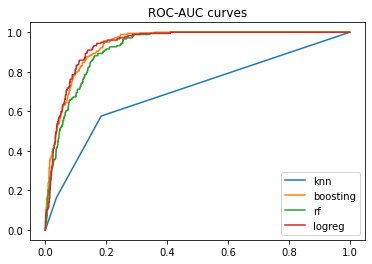

In [84]:
# Построим ROC-кривые для всех моделей

plt.plot(knn_FPR, knn_TPR, label = "knn")
plt.plot(boosting_FPR, boosting_TPR, label = "boosting")
plt.plot(rf_FPR, rf_TPR, label = "rf")
plt.plot(logreg_FPR, logreg_TPR, label = "logreg")
plt.legend()
plt.title('ROC-AUC curves')
plt.show()

In [85]:
# Сравним модели по AUC

knn_AUC = metrics.roc_auc_score(target_test3, knn_prob)
boosting_AUC = metrics.roc_auc_score(target_test3, boosting_prob)
rf_AUC = metrics.roc_auc_score(target_test3, rf_prob)
logreg_AUC = metrics.roc_auc_score(target_test3, logreg_prob)

In [86]:
pd.DataFrame({
    'AUC': [knn_AUC, rf_AUC, boosting_AUC, logreg_AUC]
}, index   = ['knn', 'rf', 'boosting', 'logreg'])

,AUC
knn,0.700701
rf,0.922271
boosting,0.938392
logreg,0.939398


Самый высокий AUC - у логистической регрессии, что видно как по расчетам, так и визуально. Метод ближайших соседей заметно уступает остальным

6. Постройте матрицу ошибок и предположите цены различных видов прогнозов.
Исходя из критерия максимизации прибыли на обучающей выборке подберите оптимальный порог прогнозирования для каждого из методов и сравните
прибыли на тестовой выборке при соответствующих порогах. Результат представьте в форме таблицы, в которой должны быть указаны как AUC, так и
прибыли (на тестовой выборке). Проинтерпретируйте полученный результат.


Запишем возможные виды прогнозов в контексте нашей задачи:


*   **TP (true positive)** - спрогнозировали, что компания является крупномасштабной и она на самом деле является крупномасштабной: $$\text{Scale}_{i} = 1\qquad \widehat{\text{Scale}}_{i}=1$$
*   **TN (true negative)** - спрогнозировали, что компания не является крупномасштабной и она на самом деле не является крупномасштабной: $$\text{Scale}_{i} = 0\qquad \widehat{\text{Scale}}_{i}=0$$
*   **FP (false positive)** - спрогнозировали, что компания является крупномасштабной, а она на самом деле не является крупномасштабной: $$\text{Scale}_{i} = 0\qquad \widehat{\text{Scale}}_{i}=1$$
*   **FN (false negative)** - спрогнозировали, что компания не является крупномасштабной, а она на самом деле является крупномасштабной: $$\text{Scale}_{i} = 1\qquad \widehat{\text{Scale}}_{i}=0$$

In [87]:
# Получим прогнозы на тестовой выборке с помощью моделей с подобранными значениями гиперпараметров

knn_pred_ts = knn_best.predict(features_test3)

rf_pred_ts = rf_best.predict(features_test3)

boosting_pred_ts = boosting_best.predict(features_test3)

logreg_pred_ts = logreg_best.predict(features_test3)

In [88]:
from sklearn.metrics import confusion_matrix

# Рассмотрим прогнозы различного вида

TN_knn, FP_knn, FN_knn, TP_knn = confusion_matrix(target_test3, knn_pred_ts).ravel()

TN_rf, FP_rf, FN_rf, TP_rf = confusion_matrix(target_test3, rf_pred_ts).ravel()

TN_boosting, FP_boosting, FN_boosting, TP_boosting = confusion_matrix(target_test3, boosting_pred_ts).ravel()

TN_logreg, FP_logreg, FN_logreg, TP_logreg = confusion_matrix(target_test3, logreg_pred_ts).ravel()

In [89]:
pd.DataFrame({
    'knn': [TN_knn, FP_knn, FN_knn, TP_knn],
    'rf': [TN_rf, FP_rf, FN_rf, TP_rf],
    'boosting': [TN_boosting, FP_boosting, FN_boosting, TP_boosting],
    'logreg': [TN_logreg, FP_logreg, FN_logreg, TP_logreg]
}, index   = ['TN', 'FP', 'FN', 'TP'])

,knn,rf,boosting,logreg
TN,1756,1760,1797,1796
FP,67,63,26,27
FN,148,110,119,145
TP,29,67,58,32


**Смоделируем ситуацию для цены ошибки предсказания переменной Масштаб**


Пусть государство запускает новую программу поддержки малых и средних предприятий. Сама программа заключается в выделении субсидий, но крупные предприятия не могут их получить. Правительству необходимо предсказать масштаб фирмы на основе определенных признаков.

Установим предполагаемые цены различных прогнозов для бюджета правительства:

*   $p_{TP} = 0 $, так как если правительство правильно определило, что компания крупная, то оно не выделило ей субсидии.
*   $p_{TN} = 20 д.е. $,  правительство правильно определило, что компания относится к МПС, выделило ей субсидии получило определенную выгоду в 20 условных денежный единиц(напр. приток инвестиций в экономику)
*   $p_{FP} = -25 д.е .$, правительство определило, что компания крупная, хотя она не крупная и не выделило необходимые средства, потеряло 25 у.е.(напр. из-за недовольства инвесторов)
*   $p_{FN} = -30 д.е. $, правительство выделило субсидии крупной компании, но не должно было, что привело к напрасной растрате средств


In [90]:
# Цены прогнозов
prices = pd.Series([0, 20, -25, -30], index = ["TP", "TN", "FP", "FN"])

In [91]:
# Оценим вероятности на обучающей выборке

knn_prob_tr = knn_best.predict_proba(features_train3)[:, 1]

rf_prob_tr = rf_best.predict_proba(features_train3)[:, 1]

boosting_prob_tr = boosting_best.predict_proba(features_train3)[:, 1]

logreg_prob_tr = logreg_best.predict_proba(features_train3)[:, 1]

In [92]:
# Возможные значения и число порогов

thresholds_knn, n_threshold_knn = np.unique(np.sort(knn_prob_tr)), np.unique(np.sort(knn_prob_tr)).size

thresholds_rf = np.unique(np.sort(rf_prob_tr))

thresholds_boosting = np.unique(np.sort(boosting_prob_tr))

thresholds_logreg = np.unique(np.sort(logreg_prob_tr))


# Число порогов

n_threshold_rf = thresholds_rf.size

n_threshold_boosting = thresholds_boosting.size

n_threshold_logreg = thresholds_logreg.size


# Векторы для сохранения прибылей при различных порогах

profits_knn = np.zeros(n_threshold_knn)

profits_rf = np.zeros(n_threshold_rf)

profits_boosting = np.zeros(n_threshold_boosting)

profits_logreg = np.zeros(n_threshold_logreg)

# Векторы различных видов прогнозов

TP_vec_knn, TN_vec_knn, FP_vec_knn, FN_vec_knn= np.zeros(n_threshold_knn), np.zeros(n_threshold_knn), np.zeros(n_threshold_knn), np.zeros(n_threshold_knn)

TP_vec_rf = np.zeros(n_threshold_rf)
TN_vec_rf = np.zeros(n_threshold_rf)
FP_vec_rf = np.zeros(n_threshold_rf)
FN_vec_rf = np.zeros(n_threshold_rf)

TP_vec_boosting = np.zeros(n_threshold_boosting)
TN_vec_boosting = np.zeros(n_threshold_boosting)
FP_vec_boosting = np.zeros(n_threshold_boosting)
FN_vec_boosting = np.zeros(n_threshold_boosting)

TP_vec_logreg = np.zeros(n_threshold_logreg)
TN_vec_logreg = np.zeros(n_threshold_logreg)
FP_vec_logreg = np.zeros(n_threshold_logreg)
FN_vec_logreg = np.zeros(n_threshold_logreg)

In [93]:
models = {'knn': [thresholds_knn, n_threshold_knn, profits_knn, TP_vec_knn, TN_vec_knn, FP_vec_knn, FN_vec_knn, knn_prob_tr, knn_prob],
          'rf': [thresholds_rf, n_threshold_rf, profits_rf, TP_vec_rf, TN_vec_rf, FP_vec_rf, FN_vec_rf, rf_prob_tr, rf_prob],
          'boosting': [thresholds_boosting, n_threshold_boosting, profits_boosting, TP_vec_boosting, TN_vec_boosting, FP_vec_boosting, FN_vec_boosting, boosting_prob_tr, boosting_prob],
          'logreg': [thresholds_logreg, n_threshold_logreg, profits_logreg, TP_vec_logreg, TN_vec_logreg, FP_vec_logreg, FN_vec_logreg, logreg_prob_tr, logreg_prob]}


for model in models:

    # рассчитаем прибыли для различных порогов
    for i in range(0, models[model][1]):

        # получаем прогнозы (на обучающей выборке) при соответствующем пороге
        prediction_model_i = (models[model][7] >= models[model][0][i]).astype(int)

        # считаем количество прогнозов различного вида
        models[model][3][i], models[model][4][i], models[model][5][i], models[model][6][i] = confusion_matrix(
          target_train3, prediction_model_i).ravel()

        # аггрегируем результаты прогнозов
        predictions_model_i = pd.Series([models[model][3][i], models[model][4][i], models[model][5][i], models[model][6][i]],
                                      index = ["TP", "TN", "FP", "FN"])
        # считаем прибыль
        models[model][2][i] = np.sum(prices * predictions_model_i)

    # достаем оптимальный порог и его индекс

    threshold_model_idx = np.argmax(models[model][2])
    threshold_model = models[model][0][threshold_model_idx]


    # считаем прибыль на тестовой выборке

    prediction_model_ts = (models[model][8] >= models[model][0][threshold_model_idx]).astype(int)

    TP_vec_model_ts, FP_vec_model_ts, FN_vec_model_ts, TP_vec_model_ts = confusion_matrix(
      target_test3, prediction_model_ts).ravel()

    predictions_model_ts = pd.Series([TP_vec_model_ts, FP_vec_model_ts, FN_vec_model_ts, TP_vec_model_ts],
                                  index = ["TP", "TN", "FP", "FN"])

    profit_model_ts = np.sum(prices * predictions_model_ts)

    models[model].append(profit_model_ts)

In [94]:
# выводим AUC и прибыли на тестовой выборке при оптимальном пороге

pd.DataFrame({
    'AUC': [knn_AUC, rf_AUC, boosting_AUC, logreg_AUC],
    'Profits on test': [models['knn'][9], models['rf'][9], models['boosting'][9], models['logreg'][9]]
}, index   = ['knn', 'rf', 'boosting', 'logreg'])

,AUC,Profits on test
knn,0.700701,31150
rf,0.922271,31150
boosting,0.938392,31150
logreg,0.939398,31150


Мы можем наблюдать неодинаковое соотншение метрик AUC и Profits по методам, а именно - прибыли одинаковы по всем методам, а AUC в методе ближайших соседей значительно меньше остальных 

7. Опишите предполагаемые связи между переменными в форме ориентированного ациклического графа (DAG). Обучите структуру Байесовской сети на обучающей выборке и сравните точность прогнозов вашего и обученного DAG на
тестовой выборке.


In [179]:
# ! pip install bnlearn

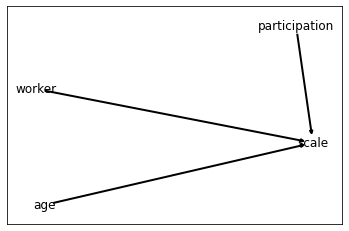

In [95]:
import bnlearn

# Визуализируем предполагаемые связи

# Стиль отображения графика
nx_options = {
    'node_color': 'white',
    'node_size': 240,
    'width': 2,
    'arrowstyle': '-|>',
    'arrowsize': 6,
}

# Связи
edges = [
    ('participation', 'scale'),         # (откуда стрелочка, куда стрелочка)
    ('age', 'scale'),
    ('worker', 'scale')

]

# Инициализируем граф
G = nx.DiGraph(directed = True)
G.add_edges_from(edges)


# Отображаем граф
np.random.seed(8)
nx.draw_networkx(G, arrows = True, **nx_options)

In [96]:
!pip install pyAgrum

In [97]:
from pyAgrum.skbn import BNClassifier
#Создание и обучение модели Байесовской сети
model = BNClassifier()
model.fit(X=features_train3,y=target_train3)

print("Точность на обучающей выборке:",model.score(features_train3, target_train3))

print("Точность на тестовой выборке:",model.score(features_test3,target_test3))


Точность на обучающей выборке: 0.879875
Точность на тестовой выборке: 0.8845


Видим, что точность ниже, чем при испоьлзованных ранее методах

8. На основании проделанного анализа выберите лучший и худший из обученных классификаторов. Обоснуйте сделанный выбор.


Примечание: необхоидмо самостоятельно сформулировать разумный критерий, в соответствии с которым будут определяться лучшая и худшая модели.

Точность прогноза после обучения совсем незначительно, но улучшилась. Однако точность превышает точность,
показанную другими классификаторами, а значит можно считать эту модель лучшей

In [98]:
best_classifier = boosting_best
worst_classifier = knn_class

По результатам проведённого анализа в качестве наилучшего классификатора был выбран метод градиентного бустинга с гиперпараметрами, оптимизированными по метрике ACC. Наихудшие результаты показал метод K ближайших соседей до подбора гиперпараметров. Различные методы оценки продемонстрировали, что бустинг обеспечивает наивысшее качество практически во всех сценариях, тогда как KNN — наименьшее.

***4. РЕГРЕССИЯ***

**1.	Отберите признаки, которые могут быть полезны при прогнозировании целевой (зависимой) переменной. Не включайте в число этих признаков переменную воздействия.**

In [99]:
# Перед началом работы импортируем необходимые пакеты
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Для отбора признаков, которые могут быть полезны в нашем исследовании для прогнозирования зависимой переменной («import», объемы импорта компании) мы обратимся к корреляционной матрице переменных, составленной нами ранее, но исключим из нее переменную воздействия («Scale», масштаб бизнеса): 

In [100]:
dff = df.loc[:, ["import", "age", "worker", "participation"]]
dff.corr()

,import,age,worker,participation
import,1.000000,0.152889,0.373163,0.286080
age,0.152889,1.000000,-0.002276,-0.421725
worker,0.373163,-0.002276,1.000000,0.062036
participation,0.286080,-0.421725,0.062036,1.000000


Заметим, что переменная «worker» имеет умеренную положительную корреляцию с целевой переменной «import» (0.3731), что делает ее потенциально полезной для прогнозирования. Переменная «participation» также имеет умеренную положительную корреляцию с «import» (0.2866), аналогично переменной «age». Таким образом, основные признаки для прогноза: «worker», «participation» и «age», а переменную «industry» мы исключаем из прогноза в силу ее низкой корреляции с зависимой переменной (0.059). Далее рассмотрим влияние переменных возраста компании, числа сотрудников и факта участия в гос. программе на объемы импорта компании.

Создадим новые выборки для анализа, которые будут включать переменные: import (таргетная переменная), age, worker, participation (переменные-регрессоры)

In [101]:
# Разделим целевую переменную и признаки
target1   = df.loc[:, ["import"]]            # целевая переменная
features1 = df.loc[:, ["age", "worker", "participation"]]    # матрица признаков
target1   = np.squeeze(target1)                # преобразуем из вектора столбца
                                             # в одномерный массив
# Разделим выборку на обучающую и тестовую
# с помощью автоматической функции
features_train1, features_test1, target_train1, target_test1 = train_test_split(
    features1, target1, test_size = 0.2, random_state = 777)

# Убедимся, что обучающая и тестовая выборки имеют верные пропорции
print(features_train1.index.size, features_test1.index.size) # признаки
print(target_train1.index.size, target_test1.index.size)     # целевая переменная

regressors_train = features_train1
regressors_test = features_test1

8000 2000
8000 2000


In [102]:
# Сохраним данные до нормализации
regressors_train_initial = regressors_train.copy()
regressors_test_initial  = regressors_test.copy()

# Подготовим объект, осуществляющий нормализацию
scaler = sklearn.preprocessing.StandardScaler().set_output(transform = "pandas").fit(regressors_train)

# Нормализуем данные
regressors_train = scaler.transform(regressors_train_initial)  # обучающая выборка
regressors_test  = scaler.transform(regressors_test_initial)   # тестовая выборка

In [103]:
regressors_train.head(5)

,age,worker,participation
8490,-0.635262,-0.191994,-0.643372
9788,-0.051623,-0.153892,1.554311
5967,-0.751990,0.580616,1.554311
7519,1.115655,-0.211044,-0.643372
8614,-1.102173,-0.215278,1.554311


**2. Выберите произвольные значения гиперпараметров, а затем оцените и сравните (между методами) точность прогнозов с помощью RMSE и MAPE:**

* на обучающей выборке.
* на тестовой выборке.
* с помощью кросс-валидации (используйте только обучающую выборку).

In [104]:
# Метод ближайших соседей
knn = KNeighborsRegressor(n_neighbors = 4,      # число соседей
                          metric = "minkowski", # метрика расстояния
                          p = 2)                # Евклидова метрика
knn.fit(regressors_train, target_train)

y_pred_train = knn.predict(regressors_train)
y_pred_test = knn.predict(regressors_test)

RMSE_knn_train = np.sqrt(mean_squared_error(target_train, y_pred_train))
RMSE_knn_test = np.sqrt(mean_squared_error(target_test, y_pred_test))
RMSE_knn_cross_val = np.mean(np.sqrt(-1 * cross_val_score(knn, regressors_train, target_train, cv=4, scoring='neg_mean_squared_error')))
MAPE_knn_train = mean_absolute_percentage_error(target_train, y_pred_train)
MAPE_knn_test = mean_absolute_percentage_error(target_test, y_pred_test)
MAPE_knn_cross_val = -1 * np.mean(cross_val_score(knn, regressors_train, target_train, cv=4, scoring='neg_mean_absolute_percentage_error'))


# Посмотрим на результат
results = pd.DataFrame(data    = {'RMSE': [RMSE_knn_train, RMSE_knn_test], 'MAPE': [MAPE_knn_train, MAPE_knn_test],},
                        index   = ['Обучающая выборка', 'Тестовая выборка'],
                        columns = ['RMSE', 'MAPE'])

print(results)

                       RMSE          MAPE
Обучающая выборка  0.206023  1.850698e+14
Тестовая выборка   0.253229  2.550163e+14


In [105]:
# Метод случайного леса
rf = RandomForestRegressor(n_estimators=100, random_state=42)

rf.fit(regressors_train, target_train)

y_pred_train = rf.predict(regressors_train)
y_pred_test = rf.predict(regressors_test)

RMSE_rf_train = np.sqrt(mean_squared_error(target_train, y_pred_train))
RMSE_rf_test = np.sqrt(mean_squared_error(target_test, y_pred_test))
RMSE_rf_cross_val = np.mean(np.sqrt(-1 *cross_val_score(rf, regressors_train, target_train, cv=5, scoring='neg_mean_squared_error')))
MAPE_rf_train = mean_absolute_percentage_error(target_train, y_pred_train)
MAPE_rf_test = mean_absolute_percentage_error(target_test, y_pred_test)
MAPE_rf_cross_val = -1 * np.mean(cross_val_score(rf, regressors_train, target_train, cv=5, scoring='neg_mean_absolute_percentage_error'))

# Посмотрим на результат
results = pd.DataFrame(data    = {'RMSE': [RMSE_rf_train, RMSE_rf_test], 'MAPE': [MAPE_rf_train, MAPE_rf_test],},
                        index   = ['Обучающая выборка', 'Тестовая выборка'],
                        columns = ['RMSE', 'MAPE'])

print(results)

                       RMSE          MAPE
Обучающая выборка  0.154828  1.331445e+14
Тестовая выборка   0.258944  2.623212e+14


In [106]:
# Градиентный бустинг
gb = GradientBoostingRegressor(n_estimators=50, random_state=3)

gb.fit(regressors_train, target_train)

y_pred_train = gb.predict(regressors_train)
y_pred_test = gb.predict(regressors_test)

RMSE_gb_train = np.sqrt(mean_squared_error(target_train, y_pred_train))
RMSE_gb_test = np.sqrt(mean_squared_error(target_test, y_pred_test))
RMSE_gb_cross_val = np.mean(np.sqrt(-1 * cross_val_score(gb, regressors_train, target_train, cv=4, scoring='neg_mean_squared_error')))
MAPE_gb_train = mean_absolute_percentage_error(target_train, y_pred_train)
MAPE_gb_test = mean_absolute_percentage_error(target_test, y_pred_test)
MAPE_gb_cross_val = -1 * np.mean(cross_val_score(rf, regressors_train, target_train, cv=4, scoring='neg_mean_absolute_percentage_error'))

# Посмотрим на результат
results = pd.DataFrame(data    = {'RMSE': [RMSE_gb_train, RMSE_gb_test], 'MAPE': [MAPE_gb_train, MAPE_gb_test],},
                        index   = ['Обучающая выборка', 'Тестовая выборка'],
                        columns = ['RMSE', 'MAPE'])

print(results)

                       RMSE          MAPE
Обучающая выборка  0.226683  2.405065e+14
Тестовая выборка   0.226328  2.480290e+14


In [107]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [108]:
# Посмотрим на сводный результат
data = {
    'Модель': ['Метод ближайших соседей', 'Случайный лес', 'Градиентный бустинг'],
    'MAPE Обучающая выборка': [MAPE_knn_train, MAPE_rf_train, MAPE_gb_train],
    'RMSE Обучающая выборка': [RMSE_knn_train, RMSE_rf_train, RMSE_gb_train],
    'MAPE Тестовая выборка': [MAPE_knn_test, MAPE_rf_test, MAPE_gb_test],
    'RMSE Тестовая выборка': [RMSE_knn_test, RMSE_rf_test, RMSE_gb_test],
    'MAPE Кросс-валидация': [MAPE_knn_cross_val, MAPE_rf_cross_val, MAPE_gb_cross_val],
    'RMSE Кросс-валидация': [RMSE_knn_cross_val, RMSE_rf_cross_val, RMSE_gb_cross_val]
}


comparison_df = pd.DataFrame(data)
comparison_df

,Модель,MAPE Обучающая выборка,RMSE Обучающая выборка,MAPE Тестовая выборка,RMSE Тестовая выборка,MAPE Кросс-валидация,RMSE Кросс-валидация
0,Метод ближайших соседей,185069797187256.38,0.21,255016328899854.38,0.25,241083317552676.94,0.26
1,Случайный лес,133144450889363.55,0.15,262321235161017.41,0.26,243988998410857.75,0.27
2,Градиентный бустинг,240506458165856.59,0.23,248028992572938.28,0.23,241564395138742.97,0.23


**Выводы:** Предпочтительная модель на основе RMSE - это случайный лес, он показывает наилучшие результаты на обучающей выборке, но градиентный бустинг демонстрирует лучшее обобщение на тестовой выборке и кросс-валидации.

**3. Для каждого метода с помощью кросс-валидации на обучающей выборке подберите оптимальные значения гиперпараметров (тюнинг). В качестве критерия качества используйте RMSE. Результат представьте в форме таблицы, в которой для каждого метода должны быть указаны:**


* изначальные и подобранные значения гиперпараметров.
* кросс-валидационное значение RMSE на обучающей выборке с исходными и подобранными значениями гиперпараметров.
* значение RMSE на тестовой выборке с исходными и подобранными значениями гиперпараметров.

**Повышенная сложность:** подберите на обучающей выборке оптимальные значения гиперпараметров градиентного бустинга ориентируясь на значение OOB (out-of-bag) ошибки. Сопоставьте гиперпараметры и точность на тестовой выборке для градиентного бустинга в зависимости от того, используется кросс-валидация или OOB ошибка.

In [109]:

# Сначала импортируем необходимые пакеты
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


# Тюнинг гиперпараметров Ближайших Соседей
param_grid = {
    'n_neighbors': range(1, 31, 3),
    # 'weights': ['uniform', 'distance'],
    # 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
grid_search_knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_knn.fit(regressors_train, target_train)
print("Лучшие параметры метода Ближнего соседа:", grid_search_knn.best_params_)

# Тюнинг гиперпараметров для метода Случайного Леса
param_grid = {
    'n_estimators': [10, 100, 200],
    'max_depth': [None, 10, 30],
    'min_samples_split': [2, 10]
}
grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search_rf.fit(regressors_train, target_train)
# Вывод лучших параметров
print("Лучшие параметры метода Случайного леса:", grid_search_rf.best_params_)



# Тюнинг гиперпараметров Градиентного бустинга
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}
grid_search_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_gb.fit(regressors_train, target_train)

# Выводим лучшие параметры для проверки
print("Лучшие параметры метода Градиентного бустинга:", grid_search_gb.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры метода Ближнего соседа: {'n_neighbors': 28}
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Лучшие параметры метода Случайного леса: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшие параметры метода Градиентного бустинга: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


In [110]:
# А теперь объединим все в сводную таблицу

# Оптимальные параметры для каждого метода
best_params_knn = grid_search_knn.best_params_
knn_best = grid_search_knn.best_estimator_
rmse_train_best_knn = np.sqrt(-grid_search_knn.best_score_)
rmse_test_best_knn = np.sqrt(mean_squared_error(target_test, knn_best.predict(regressors_test)))
best_params_rf = grid_search_rf.best_params_
rf_best = grid_search_rf.best_estimator_
rmse_train_best_rf = np.sqrt(-grid_search_rf.best_score_)
rmse_test_best_rf = np.sqrt(mean_squared_error(target_test, rf_best.predict(regressors_test)))
best_params_gb = grid_search_gb.best_params_
gb_best = grid_search_gb.best_estimator_
rmse_train_best_gb = np.sqrt(-grid_search_gb.best_score_)
rmse_test_best_gb = np.sqrt(mean_squared_error(target_test, gb_best.predict(regressors_test)))




# Таблица сводная
knn_default_params = knn.get_params()
rf_default_params = rf.get_params()
gb_default_params = gb.get_params()

data2 = {
    'Метод': ['Метод ближайших соседей', 'Случайный лес', 'Градиентный бустинг'],
    'Изначальные параметры': [knn_default_params, rf_default_params, gb_default_params],
    'Лучшие параметры': [best_params_knn, best_params_rf, best_params_gb],
    'RMSE кросс-вал начало': [RMSE_knn_cross_val, RMSE_rf_cross_val, RMSE_gb_cross_val],
    'RMSE кросс-вал лучший': [rmse_train_best_knn, rmse_train_best_rf, rmse_train_best_gb],
    'RMSE тест начало': [RMSE_knn_test, RMSE_rf_test, RMSE_gb_test],
    'RMSE тест лучший': [rmse_test_best_knn, rmse_test_best_rf, rmse_test_best_gb]
}

metrics_df = pd.DataFrame(data2)
metrics_df

,Метод,Изначальные параметры,Лучшие параметры,RMSE кросс-вал начало,RMSE кросс-вал лучший,RMSE тест начало,RMSE тест лучший
0,Метод ближайших соседей,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",{'n_neighbors': 28},0.26,0.24,0.25,0.23
1,Случайный лес,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...","{'max_depth': 10, 'min_samples_split': 10, 'n_...",0.27,0.24,0.26,0.24
2,Градиентный бустинг,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.23,0.23,0.23,0.23


На основании полученных результатов по тюнингу гиперпараметров можно сделать выводы о рассмотренных трех моделях: в случае метода **ближайших соседей** изначально использовалось 4 ближайших соседа, но тюнинг-оптимизация до 28 соседей привела к улучшению RMSE как на кросс-валидации, так и на тестовой выборке с 0.26 до 0.24. Мы видим, как увеличение числа соседей сделало модель более сглаженной и улучшило ее предсказательную способность. 

Для метода **случайного леса** изначально были использованы 100 деревьев без ограничения глубины. После тюнинга гиперпараметров мы определили, что лучше всего модель работает с 200 деревьями, максимальной глубиной 10 и минимальным количеством выборок для разделения - 10. Это заметно улучшило RMSE на тестовой выборке с 0.27 до 0.24, что свидетельствует о том, что ограничение количества деревьев и глубины помогло предотвратить возможное переобучение и улучшить обобщающую способность модели.

В нашем **градиентном бустинге** начальные параметры включали 50 деревьев с глубиной 3 и скоростью обучения 0.1. После тюнинга было настроено количество деревьев и уменьшена скорость обучения до 0.01. Несмотря на то, что RMSE практически не изменился, оставшись на уровне 0.24, это подтверждает стабильность модели даже при небольших корректировках параметров.

Таким образом, тюнинг гиперпараметров улучшил качество практически всех моделей, подчеркивая важность оптимизации для достижения лучших и более точных результатов прогнозирования. Случайный лес показал наиболее значимое улучшение на тестовой выборке, в то время как остальные модели оказались стабильными после оптимизации. 


**4. На основании проделанного анализа выберите лучший и худший из обученных классификаторов.**

Теперь на основании проведенного анализа мы можем наконец определить лучший и худший из обученных классификаторов, учитывая их способности обобщать данные и точность предсказаний с помощью значений RMSE. Случайный лес оказался лучшим классификатором для нас, поскольку после тюнинга гиперпараметров он продемонстрировал самое значимое улучшение на тестовой выборке, где показатель RMSE снизился с 0.27 до 0.24. Это говорит нам о способности метода эффективно обобщать данные и предотвращать переобучение модели. Ограничение количества деревьев и их глубины помогло модели достичь улучшенных результатов, сохраняя при этом точность на тестовых данных. 

С другой стороны, метод ближайших соседей показал наименее впечатляющие результаты: несмотря на улучшения после тюнинга, этот метод оказался менее эффективным по сравнению с градиентным бустингом и случайным лесом. Изначально его RMSE был таким же, как у случайного леса (0.26), но кросс-валидация не выявила такого уровня улучшений, как у случайного леса. Хотя увеличение числа соседей привело к некоторому улучшению, оно было не настолько значительным, чтобы превзойти результаты других двух рассмотренных нами методов. 


Таким образом, именно случайный лес является, по нашему мнению, лучшим классификатором из всех протестированных благодаря своей способности балансировать между обучением и обобщением, в то время как метод ближайших соседей (несмотря на улучшения) остается в сравнении менее эффективным и менее стабильным, то есть худшим из трех методов.



In [111]:
best_regression = rf_best

**5.	Повышенная сложность:** включите в анализ дополнительный метод регрессии, не рассматривавшийся в курсе и не представленный в библиотеке scikitlearn. Опишите данный метод (принцип работы, преимущества и недостатки) и осуществите тюнинг гиперпараметров. Сопоставьте его точность на тестовой выборке с точностью лучшего из обученных вами ранее методов.

Рассмотрим **LightGBM** — это градиентный бустинговый фреймворк, разработанный Microsoft. Этот метод не входит в стандартную библиотеку scikit-learn, но широко используется в задачах машинного обучения благодаря своей эффективности.

In [112]:
#Установка и импорт библиотек
!pip install lightgbm

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

#Создание LGBMRegressor
# Базовые параметры
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    random_state=42,
    verbosity=-1
)

# Сетка гиперпараметров для поиска
param_grid = {
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'min_child_samples': [5, 10, 20],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.7, 0.8],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}

# RandomizedSearchCV для оптимизации
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_grid,
    n_iter=20,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(regressors_train, target_train)


  Using cached lightgbm-4.6.0.tar.gz (1.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... error
    ERROR: Command errored out with exit status 1:
     command: /usr/bin/python3 /tmp/tmpk8zy02oa prepare_metadata_for_build_wheel /tmp/tmp1o_y_1a5
         cwd: /tmp/pip-install-5bq_imz8/lightgbm
    Complete output (30 lines):
    Traceback (most recent call last):
      File "/tmp/pip-build-env-epfpghr9/overlay/lib/python3.8/site-packages/scikit_build_core/_vendor/pyproject_metadata/__init__.py", line 515, in validate
        packaging.utils.canonicalize_name(self.name, validate=True)
    TypeError: canonicalize_name() got an unexpected keyword argument 'validate'
    
    During handling of the above exception, another exception occurred:
    
    Traceback (most recent call last):
      File "/tmp/tmpk8zy02oa", line 280, in <module>
        main()
      File "/tmp/tmp

ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
# Лучшие параметры LightGBM
best_params = random_search.best_params_
print("Лучшие параметры LightGBM:", best_params)

**Примечания:** Subsample - доля используемых данных для обучения модели

Reglambda - параметр снижения переобучения

Regalpha - параметр обнуления признаков

Numleaves - число листьев в каждом дереве

Nestimators - число деревьев

minchildsamples - минимальное количество тренировочных экземпляров

Learningrate - скорость обучения

Colsamplebytree - пропорция признаков в дереве


In [ ]:
!pip install lightgbm

In [ ]:
# 1. Создание Dataset объектов для LightGBM
import lightgbm as lgb
train_data = lgb.Dataset(regressors_train, label=target_train)
valid_data = lgb.Dataset(regressors_test, label=target_test, reference=train_data)

# 2. Параметры модели
params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'random_state': 42,
    'verbosity': -1
}

# 3. Тюнинг гиперпараметров с помощью RandomizedSearchCV
param_grid = {
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'min_child_samples': [5, 10, 20],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.7, 0.8],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}

lgb_model = lgb.LGBMRegressor(**params)
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_grid,
    n_iter=20,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(regressors_train, target_train)
best_params = random_search.best_params_

# 4. Обучение с ранней остановкой (правильный подход)
final_params = {**params, **best_params}

# Убираем параметры, не используемые в train()
final_params.pop('n_estimators', None)

gbm = lgb.train(
    final_params,
    train_data,
    num_boost_round=1000,
    valid_sets=[valid_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(period=50)
    ]
)

# 5. Прогнозирование и оценка
lgb_pred = gbm.predict(regressors_test)
lgb_mse = mean_squared_error(target_test, lgb_pred)
print(f"LightGBM Test MSE: {lgb_mse:.4f}")

****5 Эффекты воздействия****


При выполнении данного задания необходимо объединить обучающую и тестовую
выборки в одну.

1. Математически запишите и содержательно проинтерпретируйте потенциальные исходы целевой переменной. Объясните, как они связаны с наблюдаемыми
значениями целевой переменной.


In [113]:
#Используем объединенную выобрку:
df.head()

,import,scale,age,industry,participation,worker
0,0.00,0,4.00,1,1,14.00
1,11.58,0,18.00,1,0,35.00
2,1.83,0,11.00,0,0,20.00
3,8.46,0,3.00,0,0,256.00
4,3.63,0,6.00,0,0,23.00


Уравнение ожидаемого объема импорта когда фирма не относится к крупному бизнесу:

$$\text{Import}_{0i} = \underbrace{\underbrace{0.009\times\text{Creditworthiness}_{i}}_{g_{0}^{\text{unobs}}}  \underbrace{-35 + 0.01\times\frac{\text{Age}_{i}}{10 -\text{3*Industry}_{i}-\text{7.77*Wroker}_{i}}+1\times\ln(\text{Age}_{i}+0.2\times\text{Worker}_{i})+3\times\text{Industry}_{i}}_{g_{0}^{\text{obs}}}}_{g_{0}} + \varepsilon_{0i}\text{, где }\varepsilon_{0i}\sim \left(5\times t(8)\right)$$  

Уравнение ожидаемого объема импорта когда фирма относится к крупному бизнесу::

$$\text{Import}_{1i} = \underbrace{\underbrace{0.01\times\text{Creditworthiness}_{i}}_{g_{1}^{\text{unobs}}} \underbrace{-24 + 0.03\times\sqrt{\text{Age}_{i}\times\text{Industry}_{i}+5\times\text{Worker}_{i}}+16\times\ln(\text{Age}_{i}+0.4\times\text{Worker}_{i})+8\times\text{Industry}_{i}}_{g_{1}^{\text{obs}}}}_{g_{1}} + \varepsilon_{1i}\text{, где }\varepsilon_{1i}\sim \left(4\times t(9)\right)$$ 

Наблюдаемый ожидаемый объем импорта:

$$\text{Import}_{i} = \begin{cases}\text{Import}_{1i}\text{, если }\text{Scale}_{i}=1\\ \text{Import}_{0i}\text{, если }\text{Scale}_{i}=0\end{cases} = \\ =\text{Import}_{1i}\times\text{Scale}_{i} + \text{Import}_{0i}\times\left(1-\text{Scale}_{i}\right)$$



Наблюдаемый в данных вид масштаба фирмы можно выразить как:

$$\text{Scale}_{i} = \begin{cases}\text{Scale}_{1i}\text{, если }\text{Participation}_{i} = 1\\ \text{Scale}_{0i}\text{, если }\text{Participation}_{i} = 0\end{cases} = \\ = \text{Scale}_{1i}\times\text{Participation}_{i} + \text{Scale}_{0i}\times\left(1 - \text{Participation}_{i}\right)$$

Индивидов можно разделить на $4$ группы:


*   **Always-takers** - те, у кто $\text{Scale}_{0i}=\text{Scale}_{1i}=1$: фирма крупного масштаба независимо от того участвовала ли она в программе господдержки.
*   **Never-takers**- те, кто $\text{Scale}_{0i}=\text{Scale}_{1i}=0$: фирма НЕ крупного масштаба независимо от того участвовала ли она в программе господдержки.
*   **Compliers** - те, кто $\text{Scale}_{1i}=1$ и $\text{Scale}_{0i}=0$, то есть $\text{Scale}_{1i} > \text{Scale}_{0i}$: фирма крупного масштаба лишь в случае, если она участвовала в программе господдержки.
*   **Defiers** - те, кто $\text{Scale}_{1i}=0$ и $\text{Scale}_{0i}=1$, то есть $\text{Scale}_{1i} < \text{Scale}_{0i}$: фирма крупного масштаба лишь в случае, если она не участвовала в программе господдержки.

In [114]:
compliers = scale1 > scale0

2. Используя симулированные вами, но недоступные в реальных данных потенциальные исходы (гипотетические значения), получите оценки среднего эффекта воздействия, условных средних эффектов воздействия и локального среднего эффекта воздействия. Для ATE и LATE результаты представьте в форме таблицы, а для CATE постройте гистограмму или ядерную оценку функции плотности. Проинтерпретируйте полученные значения.

Примечание: для получения очень точных оценок эффектов воздействия с
помощью потенциальных исходов (гипотетических переменных) можно сперва
симулировать очень большого число наблюдений, например, несколько миллионов. Затем, для ускорения вычислений, для оценивания эффектов воздействия
с помощью наблюдемых значений можно использовать часть выборки, например, десять тысяч наблюдений.


Эффект воздействия рассчитывается по формуле:

$$\text{TE}_{i} = \text{import}_{1i} - \text{import}_{0i}$$

In [115]:
# Настоящие эффекты воздействия (не наблюдаются в данных)
TE = import1 - import0
print(f'TE: {TE[0:10]}')

TE: [44.30068477 37.11364239 29.08053863 51.46207261 22.41302314 24.0120573
 48.13435492 32.88954648 38.24590385 34.8630748 ]


Средний эффект воздействия находится по формуле:

$$\widehat{\text{ATE}} = \frac{1}{n}\sum\limits_{i=1}^{n}[\text{import}_{1i} - \text{import}_{0i}]$$

In [116]:
# Точное приближение среднего эффекта воздействия, то есть
# с помощью оценки, недоступной с помощью реальных данных
ATE = np.mean(TE)
print(f'ATE: {ATE}')

ATE: 35.46044349883959


Локальный средний эффект воздействия:

$$\text{LATE} = \text{E}(\text{import}_{1i} - \text{import}_{0i} | \text{scale}_{1i} > \text{scale}_{0i})$$

In [117]:
# Точное приближение локального среднего эффекта воздействия, то есть
# с помощью оценки, недоступной с помощью реальных данных
LATE = np.mean(TE[compliers])
print(f'LATE: {LATE}')

LATE: 38.59578053446613


Условный средний эффект воздействия:

$$\text{CATE}_{i} = \text{E}\left(\text{import}_{1i}|X_{i}\right) - \text{E}\left(\text{import}_{0i}|X_{i}\right) = g_{1}(X_{i}) - g_{0}(X_{i})$$

In [118]:
# Значения локальных средних эффектов воздействия
CATE = g1 - g0
print(f'CATE: {CATE}')

CATE: [34.21009109 40.23858788 31.88218728 ... 26.26048861 30.4627483
 31.97191669]


In [119]:
#Представим результаты для ATE и LATE в форме таблицы:

te_df = pd.DataFrame(data    = [ATE, LATE],
                   index   = ['ATE', 'LATE'],
                   columns = ['Гипотетические данные'])
te_df

,Гипотетические данные
ATE,35.46
LATE,38.60


ATE:


Видим, что в среднем принадлежность фирмы к крупному масштабу увеличивает среднегодовой импорта на 35.460443 млрд рублей по сравнению с мелкомасштабными фирмами.

LATE:

В среднем принадлежность фирмы к крупному масштабу увеличивает среднегодовой импорта на 38.595781 млрд рублей по сравнению с мелкомасштабными фирмами для тех фирм, которые получили господдержку.


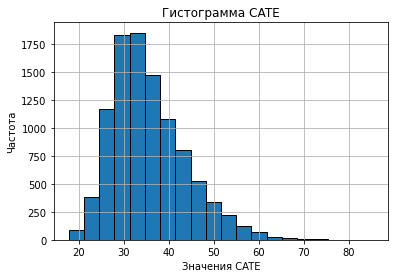

In [120]:
#Построим гистограмму для CATE:
import matplotlib.pyplot as plt

plt.hist(CATE, bins=20, edgecolor='black')
plt.title('Гистограмма CATE')
plt.xlabel('Значения CATE')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

Видим, что гистограмма характеризуется правосторонней асимметрией, что говорит о том что большинство фирм имеют умеренный или слабый эффект от принадлежности к крупному масштабу, тогда как небольшое количество фирм имеют большую отдачу в объем импорта из-за того, что они относятся к крупным компаниям

3. Оцените средний эффект воздействия как разницу в средних по выборкам тех,
кто получил и не получил воздействие. Опишите недостатки соответствующего
подхода с учетом специфики рассматриваемой вами экономической проблемы.
Примечание: в этом пункте и далее, если не сказано иное, используются лишь
наблюдаемые значения целевой переменной.


$$\text{E}(\text{import}_{1i}|\text{scale}_{i}=1) = \text{E}(\text{import}_{1i})\qquad \text{E}(\text{import}_{0i}|\text{scale}_{i}=0) = \text{E}(\text{import}_{0i})$$


Подход, указанный в задании, называется "наивный". Он опирается на допущение о независимости, которое не соблюдается в данном случае, поскольку $\text{age}_{i}$, $\text{industry}_{i}$ и $\text{worker}_{i}$ одновременно связаны и с наличием удалёнки $\text{scale}_{i}$, и с продолжительностью рабочей недели $\text{import}_{i}$.

Например, молодежь (студенты) более склонны работать в удалённом формате, чтобы было удобнее совмещать работу и учёбу, а также чаще работают на стажировках, которые подразумевают укороченную рабочую неделю, а люди без высшего образования более склонны работать физически (грузчики, кассиры и т.п.), что не подразумевает удалённой работы и может подразумевать график, например, 2-2, что может выводить продолжительность недели из стандартных 40 часов.

In [121]:
# Наивная оценка как разница в выборочных средних
ATE_naive = np.mean(import_[scale == 1]) - np.mean(import_[scale == 0])
ATE_naive

41.08756302286702

4. Используя оценки, полученные лучшими из обученных ранее классификационных и регрессионных моделей, оцените средний эффект воздействия с помощью:


• метода наименьших квадратов.

• условных математических ожиданий.

• взвешивания на обратные вероятности (в случае возникновения ошибок
убедитесь в отсутствии оценок вероятностей, равных 0 или 1 и при необходимости измените метод оценивания).

• метода, обладающего двойной устойчивостью.

• двойного машинного обучения.


Сравните результаты и назовите ключевую предпосылку этих методов. Содержательно обсудите причины, по которым она может соблюдаться или нарушаться в вашем случае. Приведите содержательную экономическую интерпретацию оценки среднего эффекта воздействия.

#### Оценивание ATE с помощью МНК

$$\widehat{\text{ATE}}_{\text{LS}} = \frac{1}{n}\sum\limits_{i=1}^{n} \underbrace{\hat{\text{E}}\left(\text{import}_{1i}|X_{i}\right) - \hat{\text{E}}\left(\text{import}_{0i}|X_{i}\right)}_{\widehat{\text{CATE}}_{i}}$$

Где:

*   $\hat{\text{E}}\left(\text{import}_{1i}|X_{i}\right)$ - оценка, полученная с использованием МНК оценок регрессионных коэффициентов $\beta$, полученных по выборке из компаний крупного масштаба $\text{scale}_{i} = 1$.
*   $\hat{\text{E}}\left(\text{import}_{0i}|X_{i}\right)$ - оценка, полученная с использованием МНК оценок регрессионных коэффициентов $\beta$, полученных по выборке из компаний не крупного масштаба $\text{scale}_{i} = 0$.

In [122]:
# Оценим средний эффект воздействия с помощью МНК
import statsmodels.api as sm

# МНК оценивание уравнения объема импорта недели для компаний не крупного масштаба
y0 = df.loc[scale == 0, ['import']]
x0 = df.loc[scale  == 0, df.columns.drop(['import', 'scale', 'participation'])]
x0 = sm.add_constant(x0)
ls0 = sm.OLS(y0, x0).fit()

# МНК оценивание уравнения объема импорта для компаний крупного масштаба
y1 = df.loc[scale  == 1, ['import']]
x1 = df.loc[scale  == 1, df.columns.drop(['import', 'scale', 'participation'])]
x1 = sm.add_constant(x1)
ls1 = sm.OLS(y1, x1).fit()

# Оценим объем импорта в год при отношении фирмы к крупномасштабной и нет с помощью полученных МНК оценок
x = df.loc[:, df.columns.drop(['import', 'scale', 'participation'])]
x = sm.add_constant(x)

# МНК оценка E(week0 | X) для всех компаний
import0_ls = ls0.predict(x)
# МНК оценка E(week1 | X) для всех компаний
import1_ls = ls1.predict(x)

# Оценки CATE
CATE_ls = np.array(import1_ls - import0_ls)

# Оценка ATE как средняя разница в прогнозах МНК оценок
ATE_ls = np.mean(CATE_ls)

ATE_ls

37.98132335038746

#### Оценивание ATE с помощью условных математических ожиданий

При соблюдении допущений об условной независимости:

$$ATE=E(\text{import}_{1i})-E(\text{import}_{0i})=E(E(\text{import}_{1i}|X_i)-E(\text{import}_{0i}|X_i))=E(E(\text{import}_{1i}|X_i, \text{scale}_i=1)-E(\text{import}_{0i}|X_i, \text{scale}_i=0))= E(E(\text{import}_{i}|X_i, \text{scale}_i=1)-E(\text{import}_{i}|X_i, \text{scale}_i=0))=\frac{1}{n}\sum_{i=1}^nE(\text{import}_{i}|X_i, \text{scale}_i=1)-E(\text{import}_{i}|X_i, \text{scale}_i=0) \to^p ATE$$

Далее получаем оценки необходимых матожиданий при помощи машинного обучения, итог выглядит следующим образом:

$$\widehat{\text{ATE}}=\frac{1}{n}\sum_{i=1}^n\hat{E}(\text{import}_{i}|X_i, \text{scale}_i=1)-\hat{E}(\text{import}_{i}|X_i, \text{sacle}_i=0)$$

In [123]:
x0 = df.loc[scale == 0, df.columns.drop(['import', 'scale', 'participation'])]
y0 = df.loc[scale == 0, ['import']]
x1 = df.loc[scale == 1, df.columns.drop(['import', 'scale', 'participation'])]
y1 = df.loc[scale == 1, ['import']]
x = df.loc[:, df.columns.drop(['import', 'scale', 'participation'])]

In [124]:
# Оценивание ATE и CATE с помощью словных матожиданий - T-learner
from copy import deepcopy
cond_exp = deepcopy(best_regression)


# Обучение оценивать E(import | X, scale = 0)
cond_exp.fit(x0, y0)

# Оценки E(import | X, scale = 0) для всех компаний,
# в том числе для тех, у кого (scale = 1).
import0_condexp = cond_exp.predict(x)

# Обучение оценивать E(import | X, scale = 1)
cond_exp.fit(x1, y1)

# Оценки E(import | X, scale = 1) для всех компаний,
# в том числе для тех, у кого (scale = 0).
import1_condexp = cond_exp.predict(x)

# Оценки CATE
CATE_cond = import1_condexp - import0_condexp

# Оенка ATE
ATE_cond = np.mean(CATE_cond)

#### Оценивание ATE с помощью взвешивания на обратные условные вероятности

При соблюдении допущения об условной независимости:
$$E(\text{scale}_i \text{import}_i / P(\text{scale}_i=1|X_i)|X_i)=E(\text{import}_i/P(\text{scale}_i|X_i, \text{scale}_i=1)P(\text{scale}_i=1|X_i)=E(\text{import}_{1i}|X_i) ⇒ E(\text{scale}_i\text{week}_i/P(\text{scale}_i|X_i)=E(E(\text{import}_{1i}|X_i))=E(\text{import}_{1i})$$

Аналогично:
$$E((1-\text{scale}_i)\text{import}_i/(1-P(\text{scale}_i=1|X_i)))=E(\text{import}_{0i})$$

Итого:
$$ATE=E(\text{scale}_i\text{import}_i/P(\text{scale}_i=1|X_i))-E((1-\text{scale}_i)\text{import}_i/(1-P(\text{scale}_i=1|X_i)))$$

Тогда оценка ATE:
$$\widehat{ATE}=\frac{1}{n}\sum_{i=1}^n \frac{\text{scale}_i\text{import}_i}{\hat{P}(\text{scale}_i=1|X_i)} - \frac{(1-\text{scale}_i)\text{import}_i}{1-\hat{P}(\text{scale}_i=1|X_i)}$$

In [125]:
# Подготовим данные
target = df.loc[:, ['scale']]
features = df.loc[:, df.columns.drop(['import', 'scale', 'participation'])]

# Подготовим метод машинного обучения
weghting_classifier = deepcopy(best_classifier)
weghting_classifier.fit(features, np.ravel(target))

# Оценим условные вероятности P(scale = 1 | X)
prob = weghting_classifier.predict_proba(features)[:, 1]

# Оценим псевдоисходы
import_pseudo = (import_ * scale) / prob - (import_ * (1 - scale)) / (1 - prob)

# Оценим ATE
ATE_IPW = np.mean(import_pseudo)

#### Оценивание ATE с помощью метода с двойной устойчивостью

Достоинство этого метода в сравнении с прошлыми заключается в том, что обеспечивается состоятельность оценки ATE, если по крайней мере один из способов дает состоятельную оценку. В прошлых же методах точность оценок ATE зависит от точности оценок соответствующих условных матожиданий или вероятностей (и если они неточные, то и ATE будет неточным).

$$\widehat{ATE}= \\
=\frac{1}{n}\sum_{i=1}^n \hat{g}_{1i}-\hat{g}_{0i} + \frac{1}{n}\sum_{i=1}^n \frac{\text{scale}_i(\text{import}_i-\hat{g}_{1i})}{\hat{g}_{on \ i}}-\frac{(1-\text{scale}_i)(\text{import}_i-\hat{g}_{0i})}{\hat{g}_{on \ i}}= \\
= \frac{1}{n}\sum_{i=1}^n \frac{\text{scale}_i\text{import}_i}{\hat{g}_{on \ i}}-\frac{(1-\text{scale}_i)\text{import}_i}{1-\hat{g}_{on \ i}} + \frac{1}{n}\sum_{i=1}^n \frac{(\text{scale}_i-\hat{g}_{on \ i})\hat{g}_{0i}}{1-\hat{g}_{on \ i}}-\frac{(\text{scale}_i-\hat{g}_{on \ i})\hat{g}_{1i}}{\hat{g}_{on \ i}}$$

где:
$$ \hat{g}_{1i}=\hat{E}(\text{import}_i|X_i, \text{scale}_i=1)$$

$$ \hat{g}_{0i}=\hat{E}(\text{import}_i|X_i, \text{scale}_i=0)$$

$$ \hat{g}_{on \ i}=\hat{P}(\text{scale}_i=1|X_i)$$

In [126]:
# Оценим ATE с помощью DR метода с двойной устойчивостью
ATE_DR = np.mean((import1_condexp - import0_condexp) + \
                 scale * (import_ - import1_condexp) / prob - \
                 (1 - scale) * (import_ - import0_condexp) / (1 - prob))

#### Оценивание ATE с помощью двойного машинного обучения

$$\widehat{ATE}=\frac{1}{n}\sum_{i=1}^n\frac{\text{scale}_i(\text{import}_i-\hat{g}_1^{(q_i)}(X_i)}{\hat{g}_{on}^{(q_i)}(X_i)} - \frac{(1-\text{scale}_i)(\text{import}_i-\hat{g}_0^{(q_i)}(X_i))}{1-\hat{g}_{on}^{(q_i)}(X_i)} + \hat{g}_{1}^{(q_i)}(X_i)- \hat{g}_{0}^{(q_i)}(X_i)$$

In [127]:
!pip install doubleml

In [130]:
# Оценим средний эффект воздействия с помощью DML
# Данные в формате, необходимом для применения DML
import doubleml as dml
dml_standard_data = dml.DoubleMLData(
                            data = df,
                            y_col = 'import',
                            d_cols = 'scale',
                            x_cols = ['age', 'industry', 'worker'])

# Метод оценивания E(Y | X, T)
g_Y = deepcopy(best_regression)

# Метод оценивания E(T | X)
g_T = deepcopy(best_classifier)

# Подготовка объекта
dml_standard = dml.DoubleMLIRM(obj_dml_data = dml_standard_data,
                               ml_g = g_Y, ml_m = g_T,
                               n_rep = 1,
                               n_folds = NFOLDS)

# Оценим параметры
dml_standard.fit()

# Сохраним оценку
ATE_dml_standard = dml_standard.coef[0]

Сравните результаты и назовите ключевую предпосылку этих методов. Содержательно обсудите причины, по которым она может соблюдаться или нарушаться в вашем случае. Приведите содержательную экономическую интерпретацию оценки среднего эффекта воздействия.

In [131]:
print(pd.DataFrame(data    = [ATE, ATE_naive, ATE_ls, ATE_dml_standard,
                             ATE_cond, ATE_IPW, ATE_DR],
                   index   = ['ATE', 'ATE naive', 'ATE ls', 'ATE dml standard',
                             'ATE cond', 'ATE IPW', 'ATE DR'],
                   columns = ['Оценка']))

                  Оценка
ATE                35.46
ATE naive          41.09
ATE ls             37.98
ATE dml standard   33.64
ATE cond           33.40
ATE IPW            28.41
ATE DR             33.47


Основные допущения этих методов — независимость и условная независимость — с высокой вероятностью нарушаются в наших данных, что негативно сказывается на точности оценки среднего эффекта воздействия (ATE)

5. Оцените локальный условный эффект воздействия с помощью:

• двойного машинного обучения без инструментальной переменной.

• двойного машинного обучения с инструментальной переменной.

Сопоставьте результаты и объясните, в чем в вашем случае будет заключаться
различие между средним эффектом воздействия и локальным средним эффектом воздействия. Приведите содержательную экономическую интерпретацию
оценки локального среднего эффекта воздействия.

#### Оценивание LATE с помощью двойного машинного обучения без инструментальной переменной

In [342]:
# Данные в формате, необходимом для применения DML
dml_standard2_data = dml.DoubleMLData(
                             data = df,
                             y_col = 'import',
                             d_cols = 'scale',
                             x_cols = ['age', 'industry', 'worker'])

# Подготовка объекта
dml_standard2 = dml.DoubleMLIRM(obj_dml_data = dml_standard2_data,
                                ml_g = g_Y, ml_m = g_T,
                                n_rep = 1,
                                n_folds = NFOLDS)

# Оценим параметры
dml_standard2.fit()

# Посмотрим на результат
print(dml_standard2)

# Сохраним оценку
LATE_dml_standard2 = dml_standard2.coef[0]

================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: import
Treatment variable(s): ['scale']
Covariates: ['age', 'industry', 'worker']
Instrument variable(s): None
No. Observations: 10000

------------------ Score & algorithm ------------------
Score function: ATE

------------------ Machine learner   ------------------
Learner ml_g: RandomForestRegressor(max_depth=10, min_samples_split=10)
Learner ml_m: GradientBoostingClassifier(max_depth=4, min_samples_leaf=4)
Out-of-sample Performance:
Learner ml_g0 RMSE: [[4.03154256]]
Learner ml_g1 RMSE: [[5.14594389]]
Learner ml_m RMSE: [[0.28467612]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
       coef  std err      t  P>|t|  2.5 %  97.5 %
scale 33.62     0.26 128.10   0.00  33.10   34.13


#### Оценивание LATE с помощью двойного машинного обучения с инструментальной переменной

In [343]:
# Данные в формате, необходимом для применения DML
dml_iv_data = dml.DoubleMLData(data = df,
                               y_col = 'import',
                               d_cols = 'scale',
                               z_cols = 'participation',
                               x_cols = ['age', 'industry', 'worker'])

# Метод оценивания E(Z | X)
g_Z = deepcopy(best_classifier)

# Подготовка объекта
dml_iv = dml.DoubleMLIIVM(obj_dml_data = dml_iv_data,
                          ml_g = g_Y, ml_m = g_Z, ml_r = g_T,
                          n_rep = 1,
                          n_folds = NFOLDS)

# Оценим параметры
dml_iv.fit()

# Посмотрим на результат
print(dml_iv)

# Сохраним оценку
LATE_dml_iv = dml_iv.coef[0]

================== DoubleMLIIVM Object ==================

------------------ Data summary      ------------------
Outcome variable: import
Treatment variable(s): ['scale']
Covariates: ['age', 'industry', 'worker']
Instrument variable(s): ['participation']
No. Observations: 10000

------------------ Score & algorithm ------------------
Score function: LATE

------------------ Machine learner   ------------------
Learner ml_g: RandomForestRegressor(max_depth=10, min_samples_split=10)
Learner ml_m: GradientBoostingClassifier(max_depth=4, min_samples_leaf=4)
Learner ml_r: GradientBoostingClassifier(max_depth=4, min_samples_leaf=4)
Out-of-sample Performance:
Learner ml_g0 RMSE: [[6.49811357]]
Learner ml_g1 RMSE: [[16.43838365]]
Learner ml_m RMSE: [[0.36473926]]
Learner ml_r0 RMSE: [[0.12135068]]
Learner ml_r1 RMSE: [[0.39884571]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
     

In [344]:
print(pd.DataFrame(data    = [ATE, ATE_naive, ATE_ls, ATE_dml_standard,
                             ATE_cond, ATE_IPW, ATE_DR,
                             LATE, LATE_dml_standard2, LATE_dml_iv],
                   index   = ['ATE', 'ATE naive', 'ATE ls', 'ATE dml standard',
                             'ATE_cond', 'ATE_IPW', 'ATE_DR',
                             'LATE', 'LATE dml standard', 'LATE dml IV'],
                   columns = ['Оценка']))

                   Оценка
ATE                 35.46
ATE naive           41.09
ATE ls              37.98
ATE dml standard    33.74
ATE_cond            33.42
ATE_IPW             28.41
ATE_DR              33.46
LATE                38.60
LATE dml standard   33.62
LATE dml IV         35.29
